$$ $$
  
<a id="contents"></a>

<center style ="font-size: xx-large; font-weight: 600; line-height: 1.1;padding: 10px">
Investigation of Distributed Image Classification with a Custom Dask Integration of a Tensorflow CNN and a Fully Dask Supported Sci-kit Learn MLP Classifier
</center>  
<center>
Group 6: Daniel Jordan, Jake Jackson, Alessandro Maria Capodaglio and Marco Lorenzetti
</center>

 
### Abstract:
<div style="text-align: justify; padding: 20px"> 
This project outlines the custom creation of a distributed tensorflow CNN with dask. The performances are admirable. With validation acccuracies close to 0.85 in just 5 epochs. The training time was clocked in at 75.72 seconds. This includes 3200 198x198 3 colour channel images. Similar sucess was achieved using the fully dask supported MLP classifier. Which outperformed the custom dask implimentation. In 5 epochs it achieved 0.99 validation accuracy. The training time is only 1.18 seconds for 5 epochs of 3200, 6084 long hitograms of orientated gradients.  
</div>

#### Key words: Dask, Sklearn,  Machine Learning, Distributed computing
----

<a id="contents"></a>

## Contents 

* [Introduction](#intro)

* [Section 1: Cloud Veneto Setup](#cloud_v) 
  * [Machines](#mach)
  * [Configuration](#conf)
  * [Maintenance](#maint)
  
* [Section 2: Image preprocessing](#imgpp)
  * [Meta Data Preamble](#preamble)
  * [Determining Image Size](#imgsize)
  * [face / noface Extraction](#extract)
  
* [Section 3: Custom Dask Tensorflow CNN](#cnn)
  
* [Section 4: Dask Sklearn Integration](#sklearn)
  * [Distributed loading of the turtle dataset](#data)
  * [Further Image preprocessing in dask](#futher_pre)
  * [Dask Sklearn Wrappers: MLP](#mlp)
  * [Dask Sklearn Joblib: Grid search](#grid)
  * [Dask Sklearn Joblib: Random Forest](#forest)
  

* [Section 5: Performance testing](#perf)
  * [Dask Further Preprocessing Performance with chunksize](#pre_perf)
  * [MLP Wrapper Performance with chunksize](#mlp_perf)

* [Section 6: Dashboard Analysis](#dash)

----

## Introduction
The project has two main concepts. The first entails the use of general dask commands to distribute the training of a tensorflow CNN. The second is the use of a dask supported scikit learn model. Dask has created a wrapper to facilitate the distribution of the scikit learn module in a professional way. The two models will be compared and contrasted. 

### Binary Image Classification
Both models will be provided with many photos that contain the face of a turtle and many photos that do not. The photos are labeled face or noface. The models must learn to distinguish between them. 

### Data / Pre-processing
The kaggle data set can be found at:  
https://www.kaggle.com/datasets/smaranjitghose/sea-turtle-face-detection  
The data set contains around 2000 images of sea turtles with their face clearly visable in the photo. Some examples are shown below.

The dataset is origionally intended for a face detection problem. Some pre-processing is required for it to suit our purpose. A csv file is provided that contains the position of boxes in the images that encloses the turtle faces. It also containes the file name of each image. This information is manipulated in a preamble() function to make face/noface image extractions easier.

The information from the preamble will be used to extract images that contain only the turtles face. Then it will be used to extract images that deffinetly do not contain a turtles face. The noface images contain a similar proportion of the origional image as the face images. This ensures the images are as similar as possible with the only difference being face or noface.

These images are ready to be placed in the TensorFlow CNN but the scikit learn module requires further preprocessing. In this preprocessing the images are grey scaled as scikit learn only supports 2D inputs. Then they are converted into hog representations. A hog is a 1D representation of the image that has colour gradient information. It facilitates easy learning for the MLP classifier.

### Chunk/Partition Size

Every distributed system has different ideal data chunk sizes. This is explored to find an ideal size for our system.

### Dashboard

The dask Dashboard has a wealth of information for performance analysis. This is used to compare the two dask ML implimentations. 


<a id="cloud_v"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  

# Section 1: Cloud Veneto setup 

<a id="mach"></a>

### Machines
---
We started using small workers with 2GB of RAM each but given Ubuntu idles with a ram usage of approximately 650 mb, it makes a lot more sense to have a medium or large RAM workers with mutiple cores so the fraction of the total ram used by the os is small. 

#### Workers, Scheduler & Jupyter

* cloudveneto.medium: 2 VCPUs, RAM 4GB,  Size 25GB

If our dataset was larger it would make more sense to have a Jupyter notebook machine with more RAM but as it stands we can perform the dask compute on our data comfortably.

<a id="fs"></a>

#### File Server
* cloudveneto.large: 4 VCPUs, RAM 8GB,  Size 25GB  

Easy to mount volume if needed but not required on our project

Note: In the begining We had a difficult to find problem with the comunication of the workers due to only the default security group.

<a id="conf"></a>

### Configuration

---

We used a light weight ubuntu build, then installed miniconda we did experiemnt with lubuntu in order to try and get an even lighter os however we decided stripping the GUI out off it too involved for the purposes of this project. But condidering that and extra permormance is propergated to all the workers a lighter os would be intreasting to explore in the future.  

It's important that each dask worker uses the same set of python packages and modules when executing the code. Therefore, we made sure all the workers had identical enviroments.We experiemnted  in docker to figure out the packages needed to complete the workflow in dask. These were exported as conda enviroment yml files.  

```
conda env export > environment_X.yml
```
Installing with
```
conda env create -f environmentX.yml
```
It's also important the workers have a place they can share files between them and the jupyter machine. A ssfh server was setup via

```
sudo sshfs -o nonempty,allow_other,default_permissions,IdentityFile=/home/ubuntu/.ssh/dasktest ubuntu@10.67.22.18:/home/ubuntu/shared_remote/ /home/ubuntu/shared_local
```
Once the worker was correctly configured we created a snapshot in cloud veneto and the image was saved.

We used this image to start mutiple identical instances. 

<a id="maint"></a>

### Maintenance
---

We used paramiko to propregate setup and updates to the cluster. The example below shows an example of a simple 
```Python
import paramiko
scheduler_ip = '10.67.22.232'
workers_ip = ['10.67.22.108','10.67.22.75','10.67.22.67','10.67.22.110','10.67.22.138','10.67.22.203']

def ssh_cmd(hostname, cmd_list):
    k = paramiko.RSAKey.from_private_key_file("/home/ubuntu/.ssh/dasktest")
    c = paramiko.SSHClient()
    c.load_host_keys(filename="/home/ubuntu/.ssh/known_hosts")
    c.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    c.connect(hostname = hostname, username = "ubuntu", pkey = k)
    for command in cmd_list:
        print ("Executing {}".format( command ))
        stdin , stdout, stderr = c.exec_command(command)
        print(stdout.read())
        print( "Errors")
        print(stderr.read())
        c.close()

        
def ex_conda(cmd): #put command in through conda 
    return "source ~/miniconda3/bin/activate base; " + cmd


for worker in workers_ip:
    ssh_cmd(worker,['ls \shared_local'])
```

Issuing a command to all workers in parallel in dask

i.e clearing unallocated memory command
```Python
import ctypes
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)
client.run(trim_memory)
```

In [7]:
#### Imports and Fnctional Code

import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import dask.array as da
from pathlib import Path
from dask.distributed import wait
from dask.distributed import Client
import pickle
#from dask_image.imread import imread
from skimage import io, transform
import dask.array as da
import dask.delayed
from tensorflow.keras import models, layers
import tensorflow as tf
import pandas as pd
import re
import os
import time
import timeit
# are you on cloud veneto?
onCV = False
from dask.distributed import Client
if onCV:
    # must run to following command on this jupyter machine to set up cluster.  
    # dask-ssh 10.67.22.{178,193,212,246,25,52} --scheduler 10.67.22.233 --log-directory /home/ubuntu/daskShared_local/logs --ssh-username ubuntu --ssh-private-key /home/ubuntu/.ssh/dasktest
    client = Client('10.67.22.232:8786')
    print('Connecting to CV cluster')

else:
    #after doing docker-compose up the cluster is ready to connect
    client = Client('dask-scheduler:8786')
    print('Connecting to docker cluster')
    #dask-scheduler is an alias for the ip address of the scheduler. I believe it is set up in the image of the jupyter notebook machine. 

#set paths
if onCV: path_lbl = Path('/home','ubuntu','shared_local','labels.csv')
else: path_lbl = Path('/opt','workspace','data','labels.csv')

if onCV: path_img = Path('/home','ubuntu','shared_local','images')
else: path_img = Path('/opt','workspace','data','images')

#this file will be writted to all of the workers into this path.
#this path should not be in the folder that is shared between workers.
if onCV: path_weights = Path('/home','ubuntu','daskNotShared','weights.pkl')
else: path_weights = Path('/weights/weights.pkl')
    
if onCV: path_acc = Path('/home','ubuntu','daskNotShared','acc.pkl')
else: path_weights = Path('/weights/weights.pkl')

if onCV: path_loss = Path('/home','ubuntu','daskNotShared','loss.pkl')
else: path_weights = Path('/weights/weights.pkl')    
    
if onCV: path_face = Path('/home','ubuntu','shared_local','face')
else: path_face = Path('/opt','workspace','data','face')

if onCV: path_noface = Path('/home','ubuntu','shared_local','noface')
else: path_noface = Path('/opt','workspace','data','noface')
client

Connecting to docker cluster


<Client: 'tcp://172.22.0.2:8786' processes=2 threads=8, memory=13.94 GiB>

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="imgpp"></a>

# Section 2: Image Preprocessing 


<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="preamble"></a>

## Meta Data Preamble 

In the preamble the labels.csv is loaded into a dask dataframe. Some basic operations are applied to get information that will be usefull later for the image pre processing. The data comefortably fits into ram and so dask automatically gives it one partition. 

First the task graph will be inspected for the entire preamble. Then the change in the task graph will be inspected as we change the number of partitions.

Then an analysis is performed for the time taken to perform the preamble as a function of the number of partitions. As the data comefortably fits into ram there is no risk of crashing the workers from too few larger partitions. It is expected that it will run the fasted with the number of partitions that equal the number of workers. This is because there is less time reading and writing. Similarly as the number of partitions grows beyond the number of workers it is expected the time taken will increase linearly. As then number of reads increases linearly.

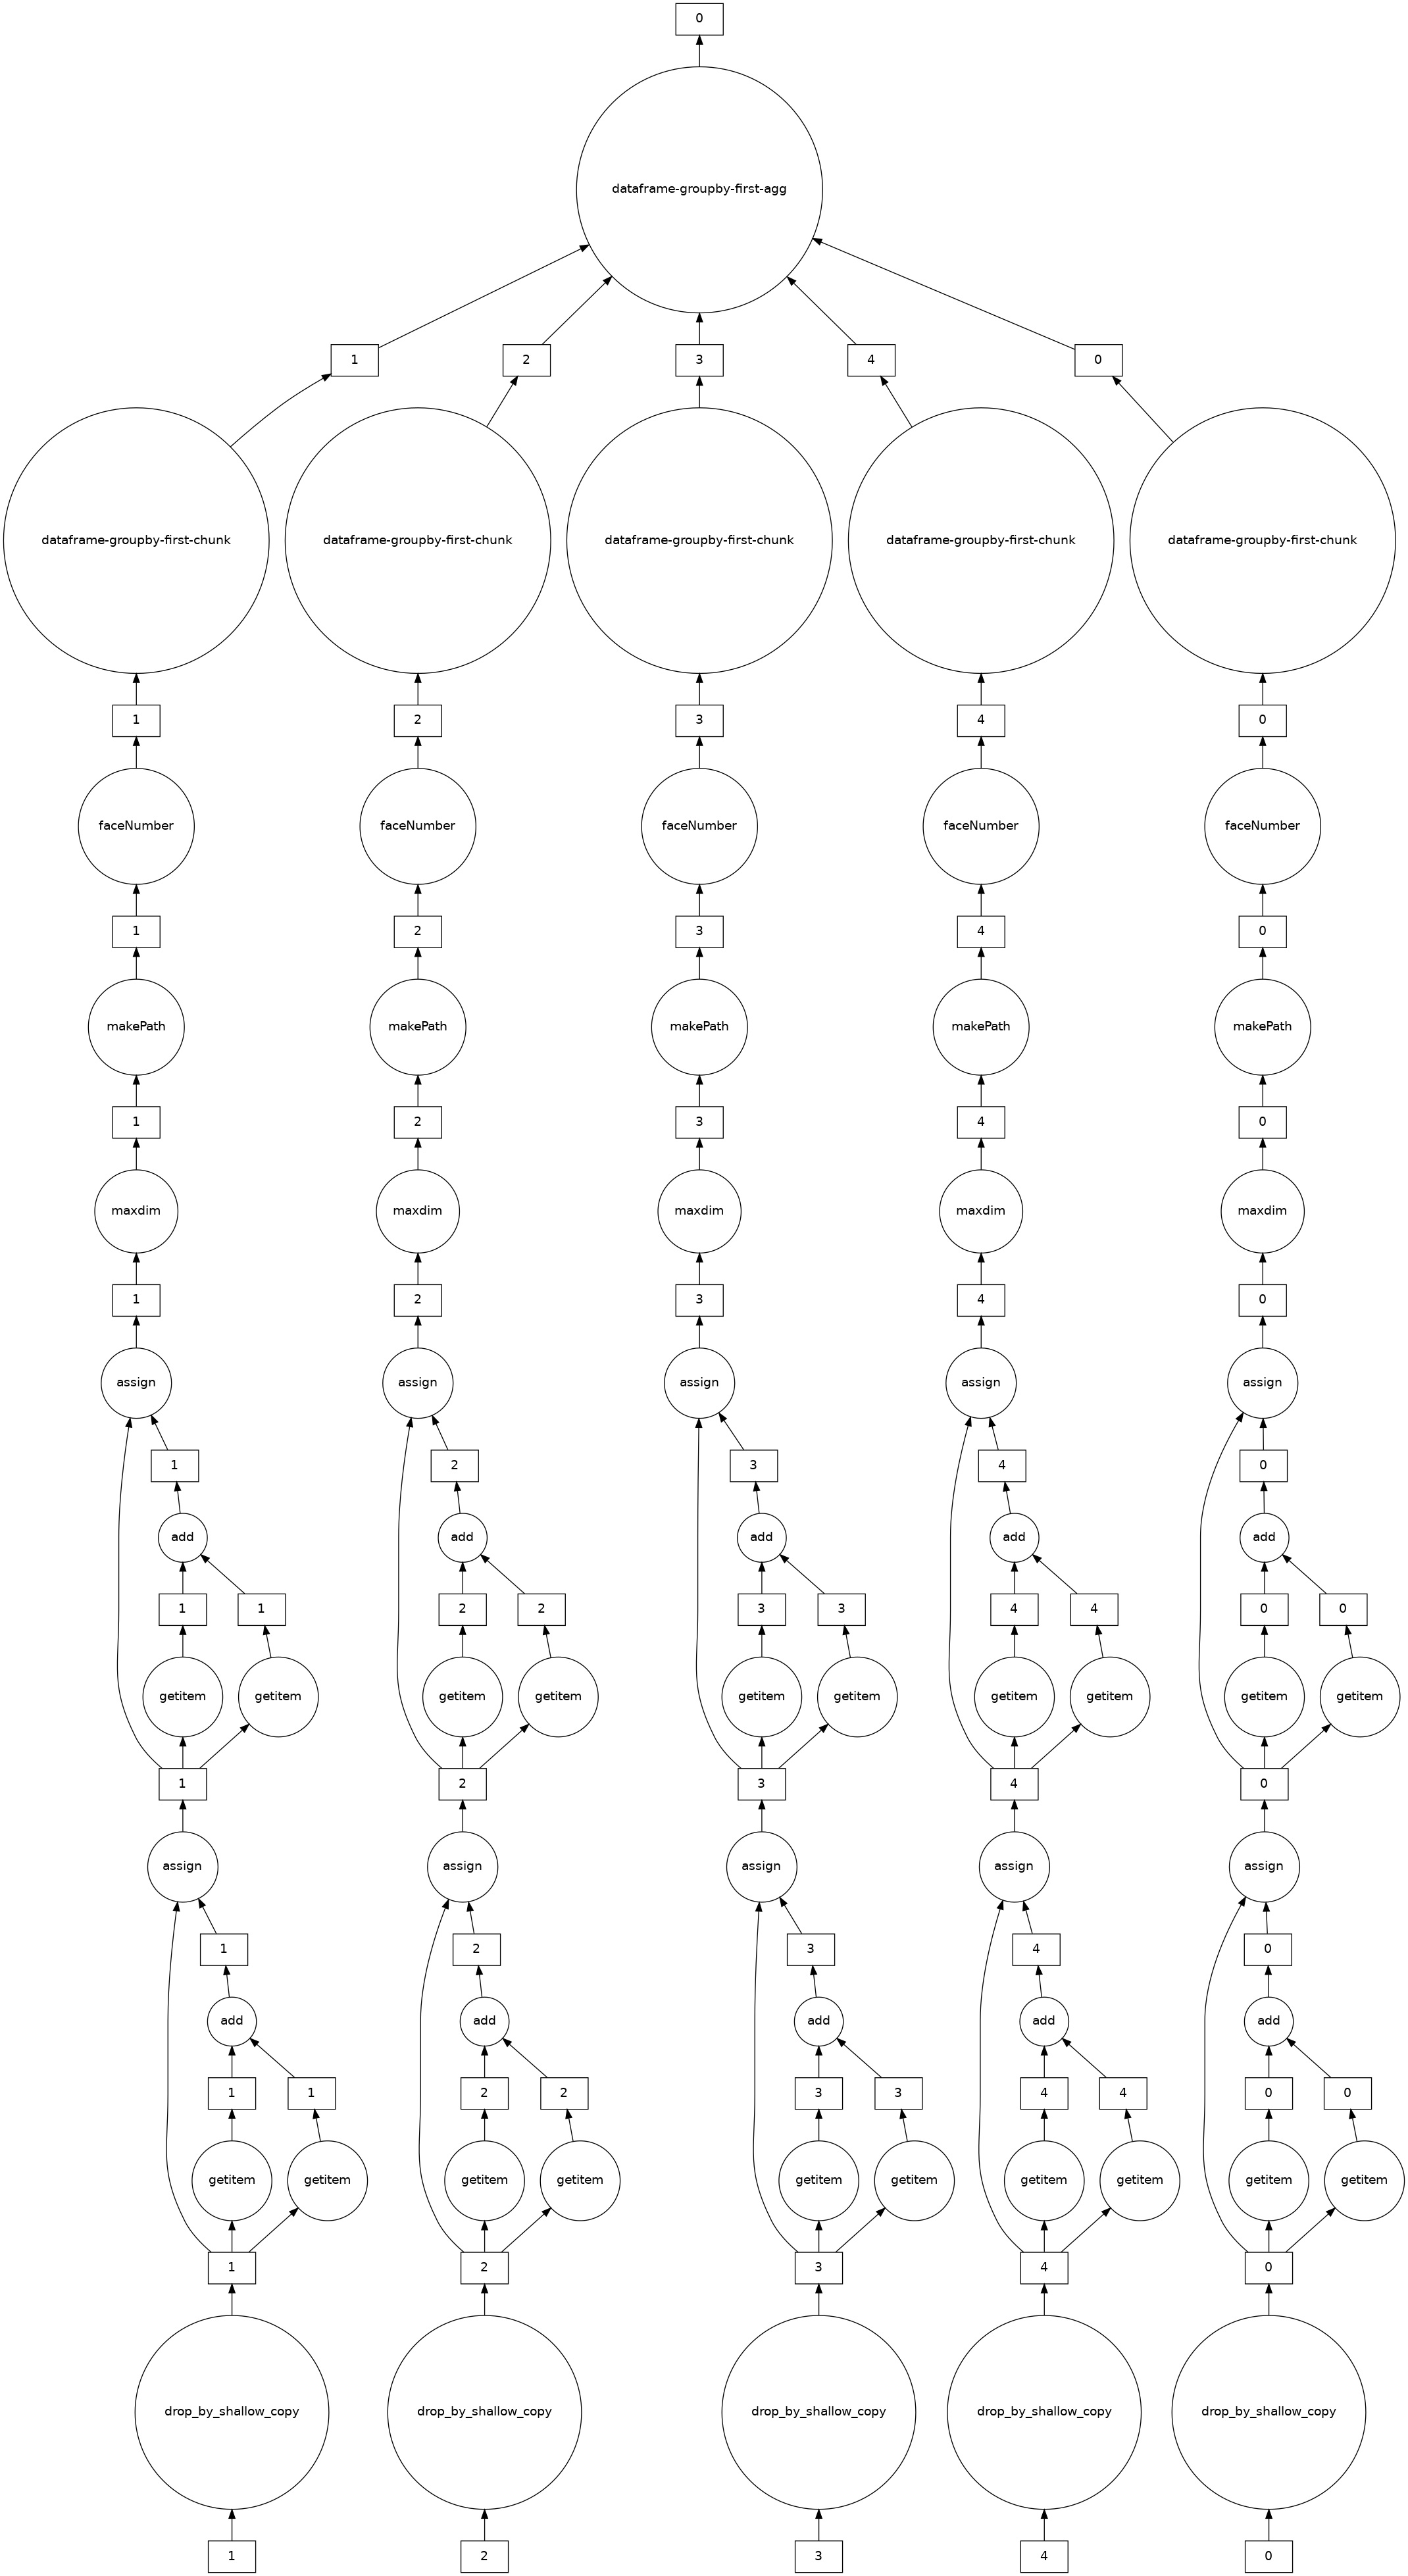

In [15]:
def loadData():
    df = dd.read_csv(path_lbl)
    df.columns = ['species', 'box_topleft_x', 'box_topleft_y', 'box_width', 'box_height', 'filename',       'image_width', 'image_height']
    meta = df.head(1)
    return df, meta

df, meta = loadData()

def preamble(df, meta, persist=False):
    df = df.drop(columns='species')
    meta = meta.drop(columns = 'species')
    #adding bottom right box corners
    # co-ordinated measured from top left corner of image being 0
    df['box_bottomright_x'] = df['box_topleft_x'] + df['box_width']
    df['box_bottomright_y'] = df['box_topleft_y'] + df['box_height']
    meta['box_bottomright_x'] = 1
    meta['box_bottomright_y'] = 1
    
    # adding the max box dimension for best size analysis
    def maxdim(partition):
        partition['max_box_dim'] = np.maximum(partition['box_width'],partition['box_height'])
        return partition
    meta['max_box_dim'] = 1
    df = df.map_partitions(maxdim, meta = meta)
    
    # adding paths for easier file reading
    def makePath(partition):
        def makePath2(row):
            return Path(path_img,row['filename'])
            
        partition['file_path'] = partition.apply(makePath2, axis = 1)
        return partition
    meta['file_path'] = Path()
    df = df.map_partitions(makePath, meta = meta)
    
    # add a face number (taken fromt he file name) to save the files properly
    def faceNumber(partition):
        def faceNumber2(row):
            filename = row['filename']
            found = re.search('[0-9]+',filename)
            return filename[found.start():found.end()]
        
        partition['face_number'] = partition.apply(faceNumber2, axis = 1)
        return partition
    meta['face_number'] = 'a String'
    df = df.map_partitions(faceNumber, meta = meta)

    # getting rid of images with extra faces
    df = df.groupby('filename', sort = False).first()
    meta = meta.drop(columns='filename')
    if persist==True: df = df.persist()
    
    return df, meta
df, meta = loadData()
df = df.repartition(npartitions=5).persist()
predf, premeta = preamble(df, meta)
predf.visualize()

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="imgsize"></a>
## Determining Image Size 
A deep learning model must accept data of the same size. So we will rescale all of our images to this size. The mode of the max box dimension will be used as our default image size.

The distrobuted process is invesigated with visualizations. The performance is not of interest in this section.

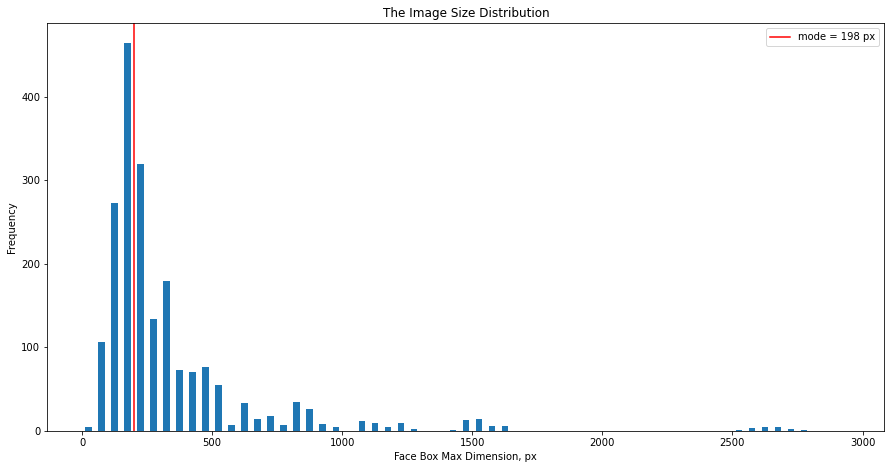

In [147]:
df, meta = loadData()
df, meta = preamble(df,meta)
max_box_dim = df['max_box_dim'].to_dask_array()
box_dim_mode = df['max_box_dim'].mode().compute()[0]
bins = np.arange(0,3000,50)
h, bins = da.histogram(max_box_dim,bins)
bincenter = (bins-25)[1:]
figimgsz = plt.figure(figsize=(15,7.5))
plt.bar(bincenter,h.compute(),width=25)
plt.axvline(box_dim_mode, color = 'red', label='mode = '+str(box_dim_mode)+' px')
plt.title('Image Size Distribution')
plt.xlabel('Face Box, Max Dimension, px')
plt.ylabel('Frequency')
plt.legend()

### Visualization of Distributed Mode Process

In the reduction chunk I suspect the data is reduced to the frequency of each number. Each worker doesn't know the frequencies calculated by the other workers. Thus a worker is given the task of collecting the results, summing them together and reducing it into one most frequently apparent value. 

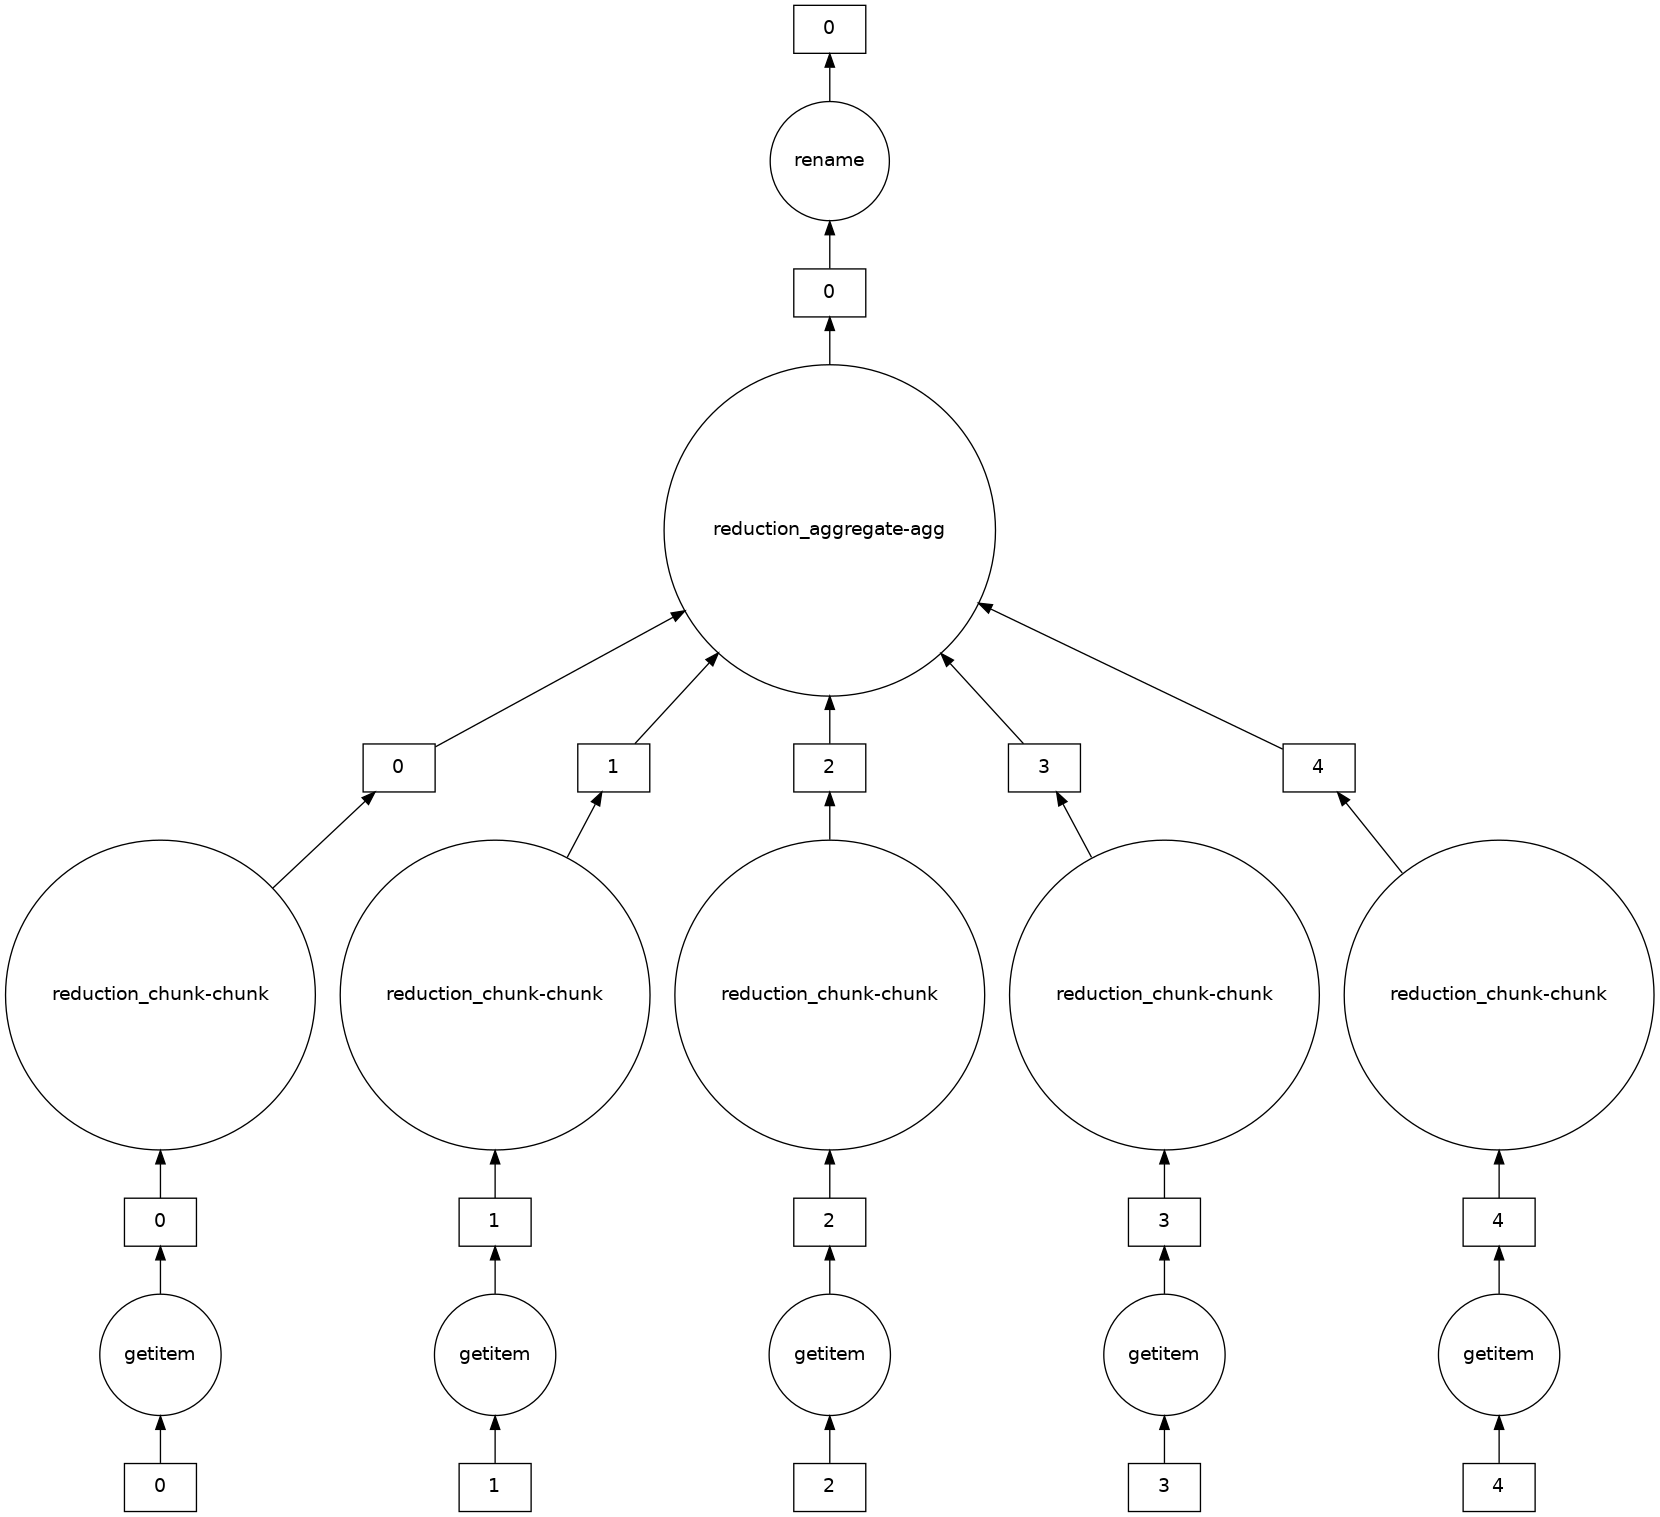

In [152]:
df = df.persist()
df = df.repartition(npartitions=5).persist()
box_dim_mode = df['max_box_dim'].mode()
box_dim_mode.visualize()

### Visualization of Distributed Histogram Process

In the histogram sum nodes I suspect the workers are summing up the frequencies in each bin. They don't know what frequencies the other workers have summed. The workers results have to be summed. Dask has decided to do this in two steps. Have two workers collect different results and sum them. Then have a final worker sum the result of these two. The partital sum seems to be imbalanced. One worker sums 4 sets of the results whilst another only has one. It is shown by increasing the number of partitions dask finds a better balance. 

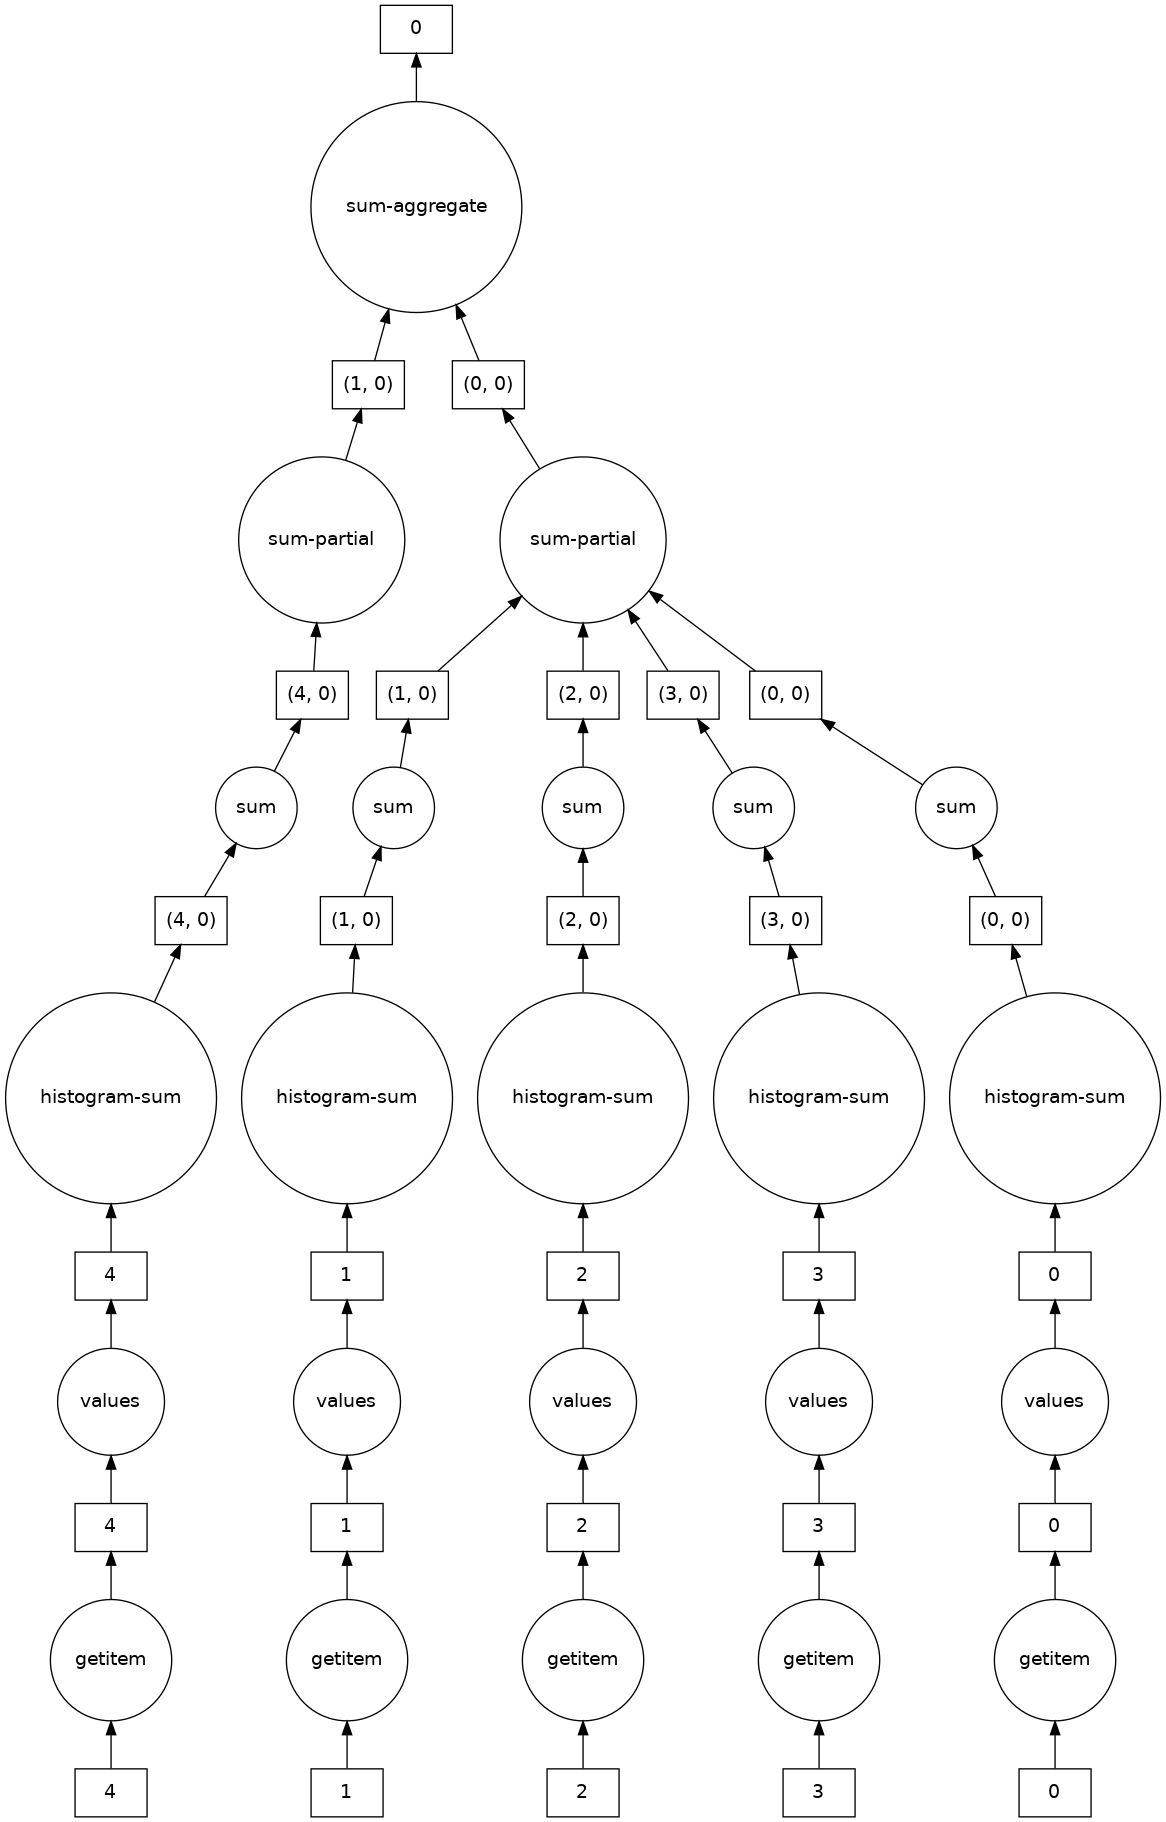

In [158]:
df, meta = loadData()
df, meta = preamble(df,meta)
df = df.repartition(5).persist()
max_box_dim = df['max_box_dim'].to_dask_array()
h, bins = da.histogram(max_box_dim,bins)
h.visualize()

### 8 partitions
It was strange that dask had one worker do 4 sums and another do 1. To investigate a little further I tried 8 partitions. With 8 partitions dask spread the partial sum more evenly.

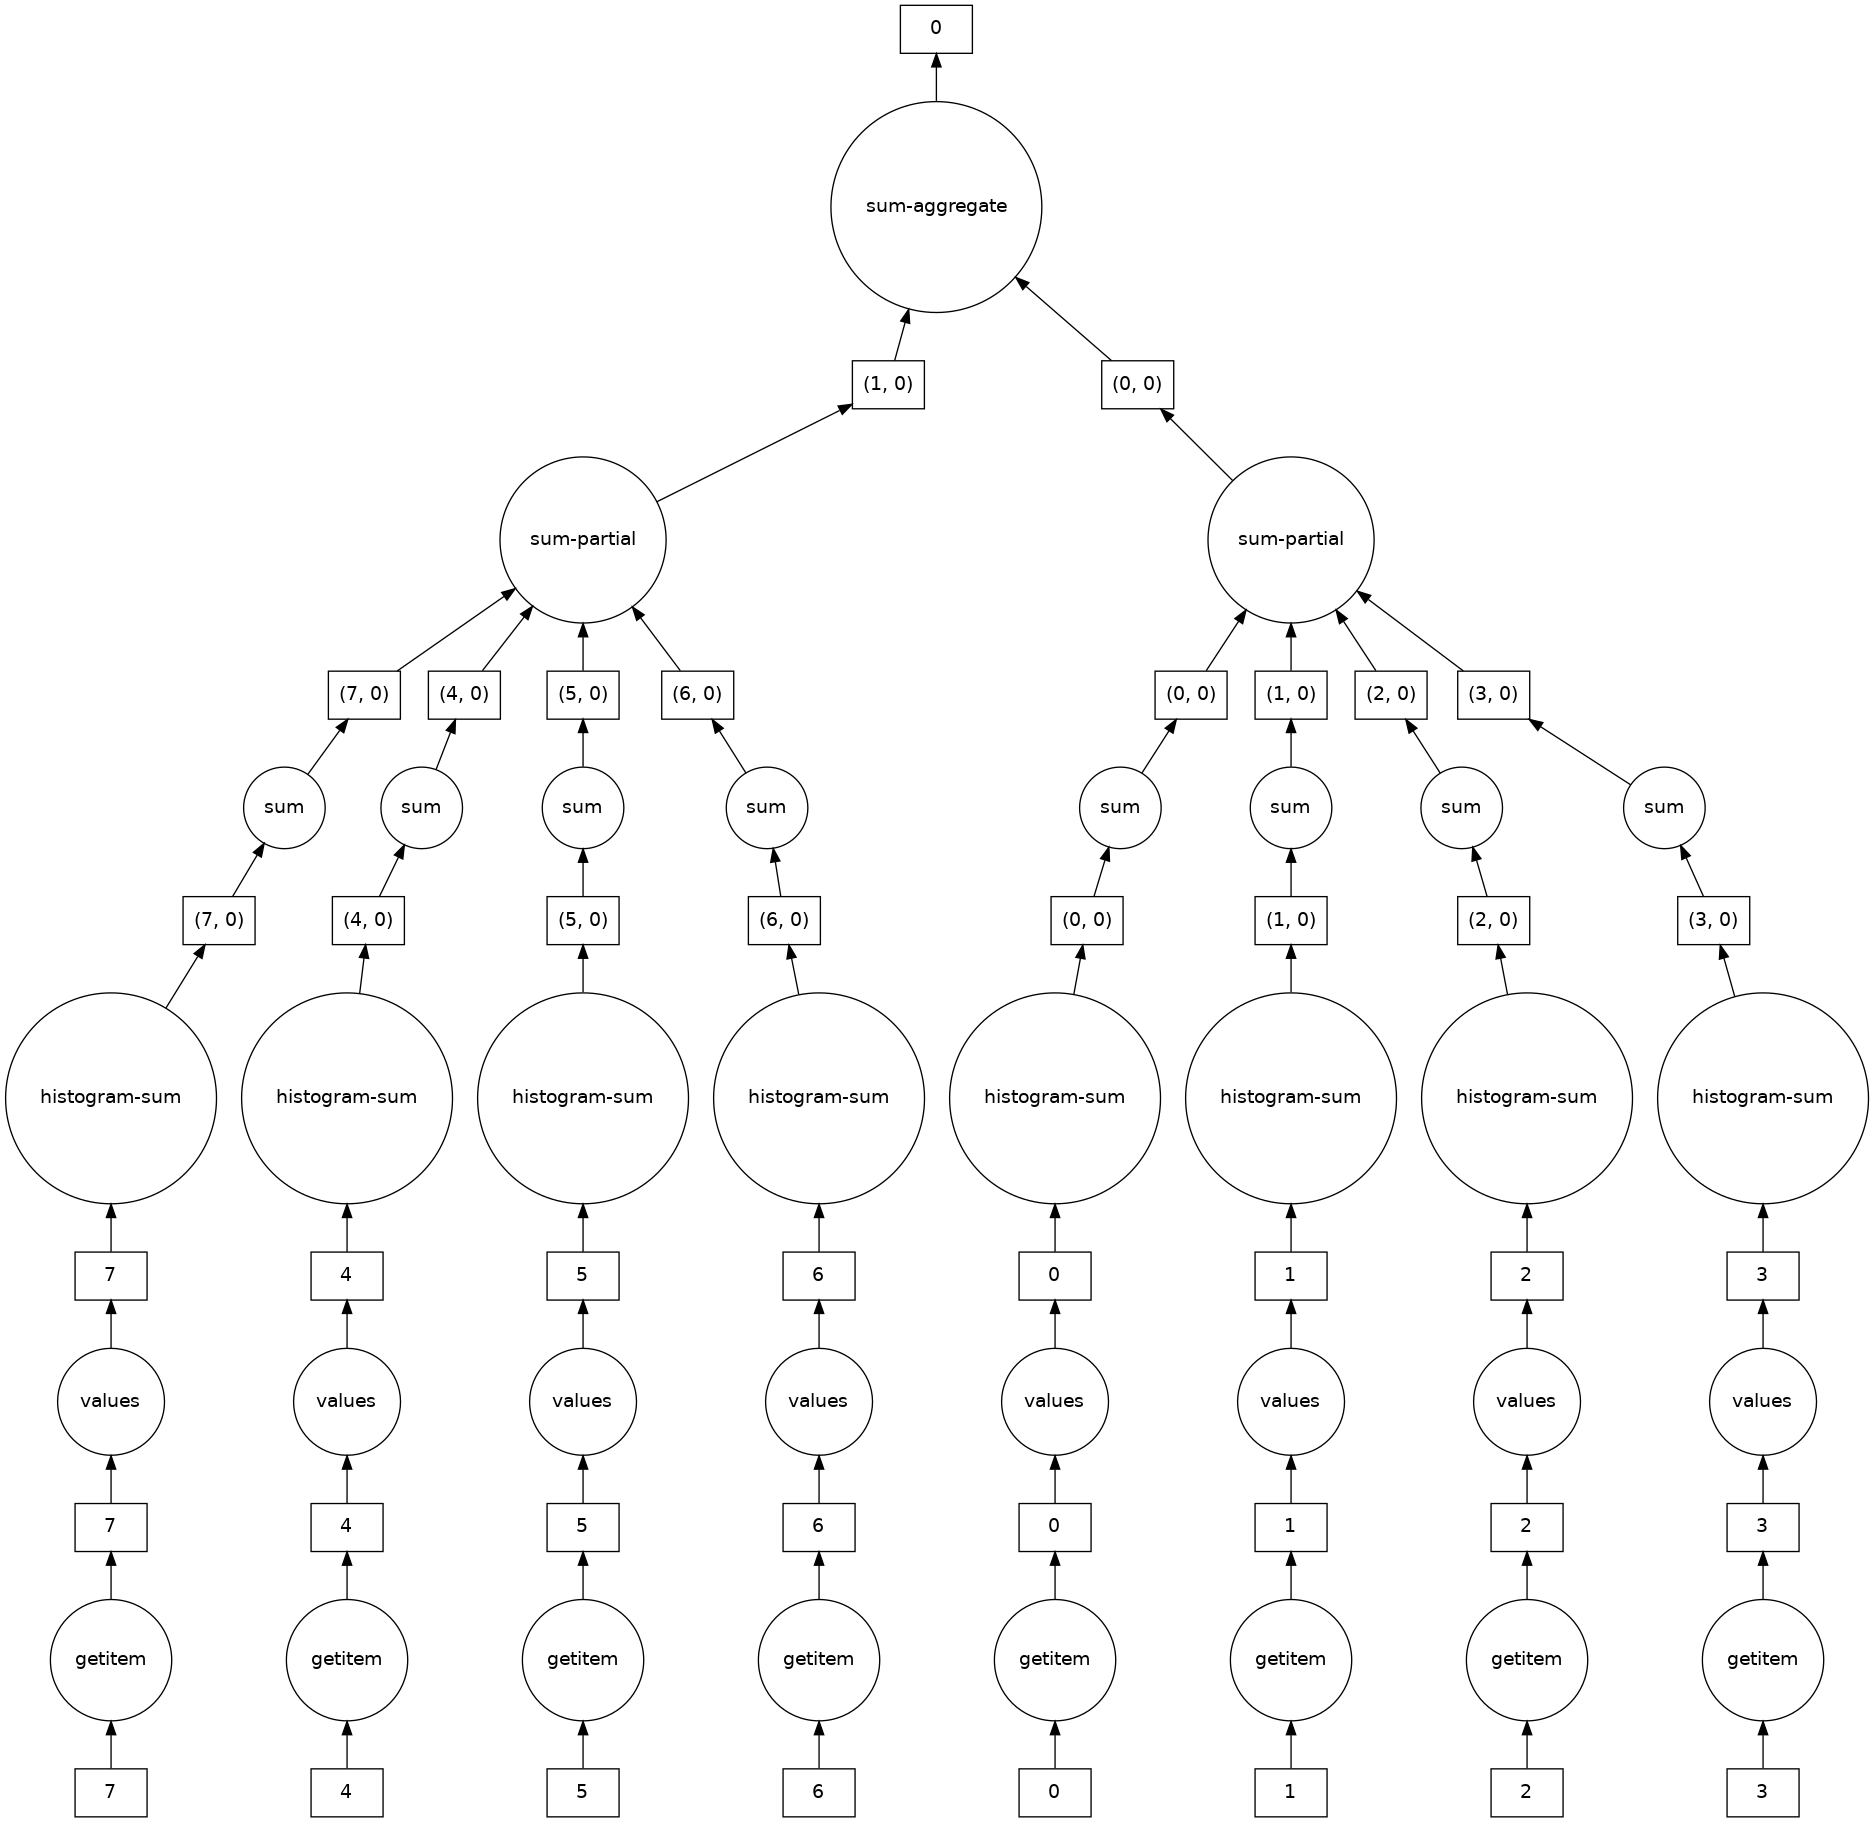

In [157]:
df, meta = loadData()
df, meta = preamble(df,meta)
df = df.repartition(8).persist()
max_box_dim = df['max_box_dim'].to_dask_array()
h, bins = da.histogram(max_box_dim,bins)
h.visualize()

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="extract"></a>
## face / noface Extraction
The data in the dask data frame will be used to crop and resize the turtle images to 198x198. The turtle face will be extracted from each photo to create the Face samples. A random portions of each photo, the same size as the face portion, will be selected to create to noFace samples.

To accomplish this the face information of the data frame needs to be linked with it's corrosponding image. If I load all of the images into a dask array. It is impossable to know their order and how they match up with the dataframes information.

The first approach to overcome this is to go through each row of the dask dataframe and load the corrosponding image, manipulate it and then add it to a dask array for further processing. This works but adds an unecessary amount of reading time to the process.

The second approach is to load the images into the dataframe as a column. Then it is already there close to the face information. And can be used multiple times without the need to reload the images. This significantly increases the size of the datframe and so a small number of partitions can kill the workers.


### face Extraction

The ML model will be trained to classify partial images of turtles into face and noace. The provided images of turtles will be processed to extract the turtles faces. Labels have been provided represent a box surrounding the turtles face in each image. The boxes are not square. The ML model needs all the images to be the same size. To overcome this the shorter side is made equal to the longer size and the image is cropped to the new box. 

The next code cell will do the following:
 - run a function getFace on each dask dataframe partition, which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getFace2 on each row of the partition.
        - This function will load the image associated with the row
        - Crop the image to a square the box that is mostly taken up by the turtles face
        - Save the new image to a file. 

CPU times: user 182 ms, sys: 33.4 ms, total: 215 ms
Wall time: 452 ms


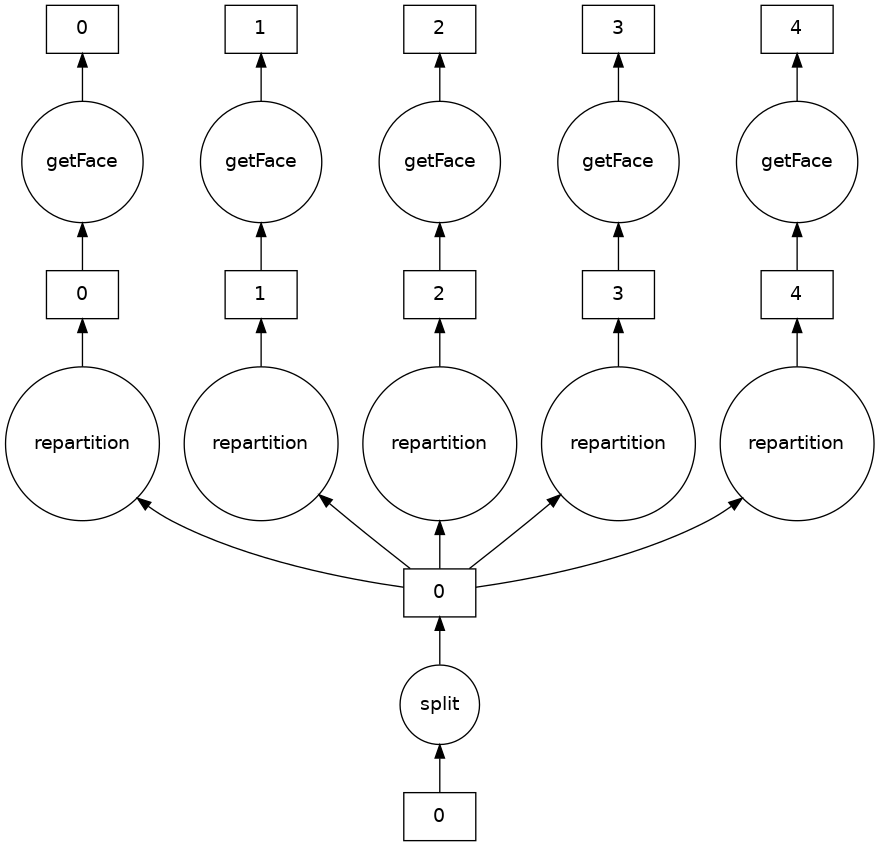

In [17]:
%%time
from skimage import util
def getFace(partition):
    def getFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        y = image_info['box_topleft_y']
        x = image_info['box_topleft_x']
        dim = {'box_width':image_info['box_width'],'box_height':image_info['box_height']}
        max_dim_key = max(dim, key = dim.get)
        max_dim = image_info['max_box_dim']
        dif = np.abs(image_info['box_width'] - image_info['box_height'])
        half_dif = int(dif/2)
        if max_dim_key == 'box_width':
            new_top = y-half_dif
            new_bottom = new_top + max_dim
            pad_width = 0
            if(new_top < 0):
                pad_width = -new_top
                new_top = 0
            if(new_bottom > image_info['image_height']):
                pad_width = new_bottom - image_info['image_height']
                new_bottom = image_info['image_height']
            
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ new_top : new_bottom, x : x+max_dim, :]
            del new_top, new_bottom, pad_width
            
        if max_dim_key == 'box_height':
            new_left = x-half_dif
            new_right = new_left + max_dim
            pad_width = 0
            if(new_left < 0):
                pad_width = -new_left
                new_left = 0
            if(new_left > image_info['image_width']):
                pad_width = new_left - image_info['image_width']
                new_left = image_info['image_width']
            im = np.pad(im, pad_width = [(pad_width,pad_width),(pad_width,pad_width),(0,0)], mode = 'reflect')
            face = im[ y : y+max_dim, new_left : new_right, :]
            del new_left, new_right, pad_width
        face = transform.resize(face,(198,198,3))
        face = util.img_as_ubyte(face)
        del im, y, x, dim, max_dim_key, max_dim, dif, half_dif
        
        path = Path(path_face,'face_'+image_info['face_number']+'.jpg')
        io.imsave(path,face)
        
    partition['face_img'] = partition.apply(getFace2, axis = 1)

df, meta = loadData()
df, meta = preamble(df, meta, persist=True)
df = df.repartition(npartitions=5)
meta = pd.DataFrame({'none':[None]})
facedf = df.map_partitions(getFace, meta = meta)
del df
facedf.visualize()

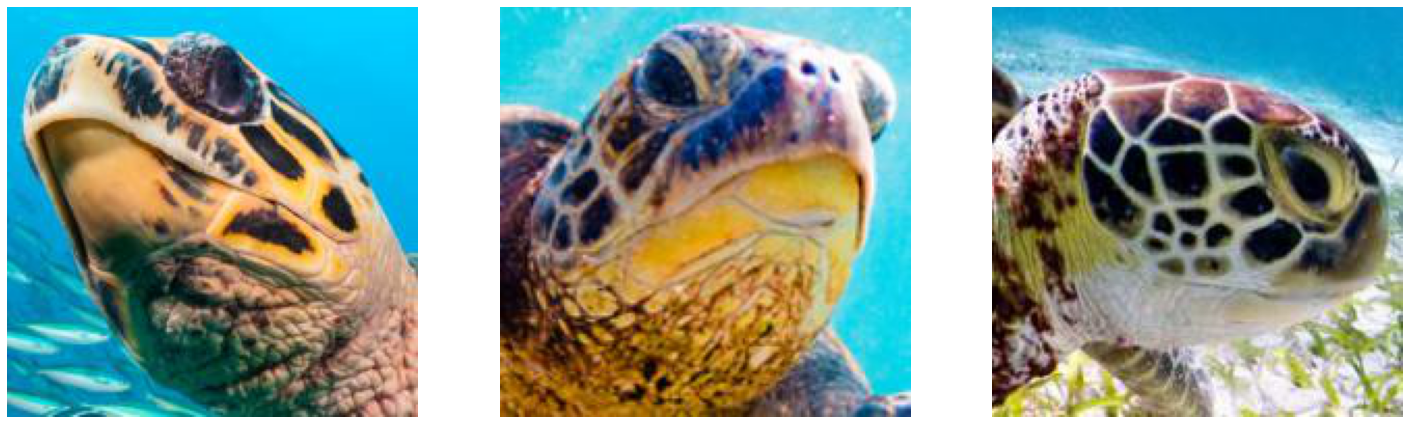

In [65]:
img1 = io.imread(Path(path_face,'face_10.jpg'))
img2 = io.imread(Path(path_face,'face_123.jpg'))
img3 = io.imread(Path(path_face,'face_45.jpg'))

figTf, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,25))
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
a=1

### noface Extraction

The ML model will be trained to classify partial images of turtles into face and no face. The provided images of turtles will be processed to extract sections of those images that do not contain a face. To do this the information in the dataframe of the face location is required.

The next code cell will do the following:
 - run a function getNoFace on each dask dataframe partition which is a pandas dataframe
 (Each partition can be ran on a different core/thread)
    - run a function getNoFace2 on each row of the partition.
        - This will load the image associated with the row
        - split it into four images, one on each side of the turtle face box, these images are called sides
        - Take the largest of these four sides and take a random chunck about the same size as the face box. This is the extracted noFace image. (This makes sure the no face images are as similar as possible to the face image, in terms of resolution and amount of the turtle visable)
        - Sometimes the largest side is smaller then the face box. In this case the largest random square is taken as the noFace Image.
        - The noFace image extraced is resized to 198 by 198 pixels. (This is the mode of the largest facebox dimension, and so most of the face images are limited to this ammount of imformation.)
        - The the new noFace image is then saved to a file.
 

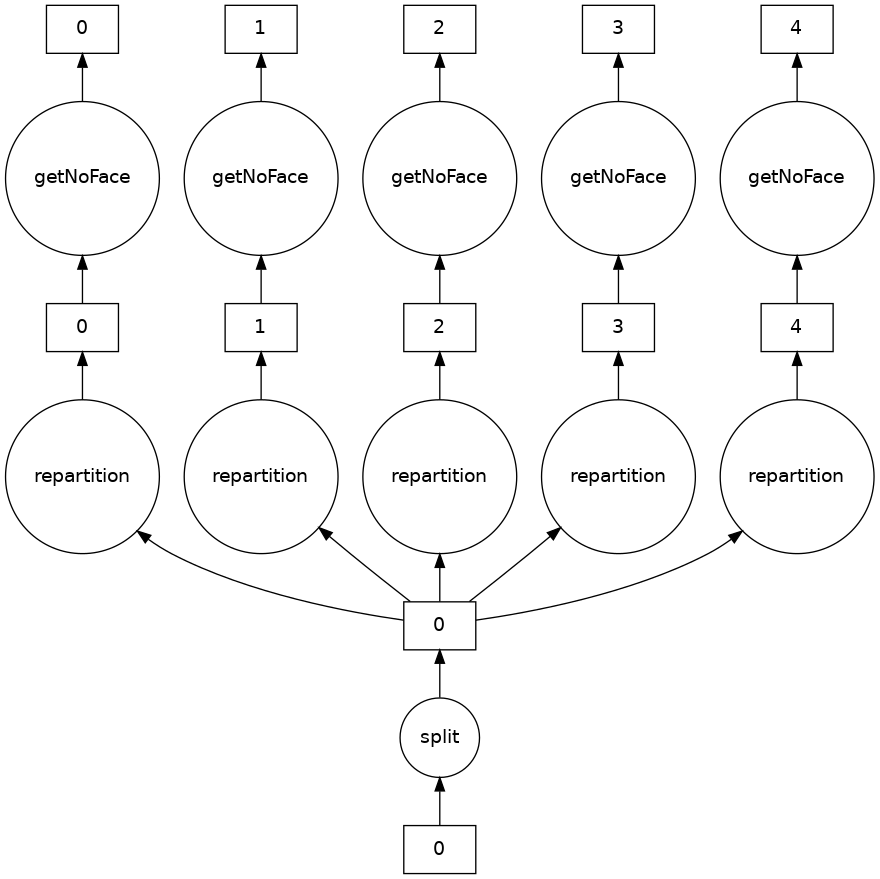

In [44]:
def getNoFace(partition):
    def getNoFace2(image_info):
        im = io.imread(image_info['file_path'])
        im = im[:,:,:3]# remove fourth channel if it exists
        im_left = im[:, 0:image_info['box_topleft_x'] ,:]
        im_right = im[:, image_info['box_bottomright_x']: ,:]
        im_top = im[0:image_info['box_topleft_y'],:,:]
        im_bottom = im[image_info['box_bottomright_y']:,:,:]
        del im
        var = locals()
        sizes ={'im_left':np.min(np.shape(im_left)[0:2]),'im_right':np.min(np.shape(im_right)[0:2]),'im_top':np.min(np.shape(im_top)[0:2]),'im_bottom':np.min(np.shape(im_bottom)[0:2])}
        max_side_key = max(sizes, key = sizes.get)
        rand_gen = np.random.default_rng(12345)
        max_box_dim = np.max([image_info['box_width'],image_info['box_height']])
        if sizes[max_side_key]<max_box_dim:
            side = var[max_side_key]
            dim = np.shape(side)[0:2]
            side_max_ind = np.argmax(dim)
            side_min_ind = not side_max_ind
            high = dim[side_max_ind] - dim[side_min_ind]
            along = rand_gen.integers(low = 0, high = high)
            if(side_max_ind == 0):
                noface = side[along:along+dim[side_min_ind],:,:]
            elif(side_max_ind == 1):
                noface= side[:, along:along+dim[side_min_ind] ,:]
            del side, dim, side_max_ind, side_min_ind, high, along
        else:
            side = var[max_side_key]
            side_width = np.shape(side)[1]
            side_height = np.shape(side)[0]
            rtlx = rand_gen.integers(low = 0, high = side_width - max_box_dim)
            rtly = rand_gen.integers(low = 0, high = side_height - max_box_dim)
            noface = side[rtly:rtly+max_box_dim, rtlx:rtlx+max_box_dim, :]
            del side, side_width, side_height, rtlx, rtly
        del var, sizes, max_side_key, rand_gen, max_box_dim
        noface = transform.resize(noface,(198,198,3)) 
        io.imsave(path,noface)
    partition['noface_img'] = partition.apply(getNoFace2, axis = 1)

df, meta = loadData()
df, meta = preamble(df,meta, persist=True)
df = df.repartition(npartitions=5)
meta = pd.DataFrame({'none':[None]})
nofacedf = df.map_partitions(getNoFace, meta = meta)
del df
nofacedf.visualize()

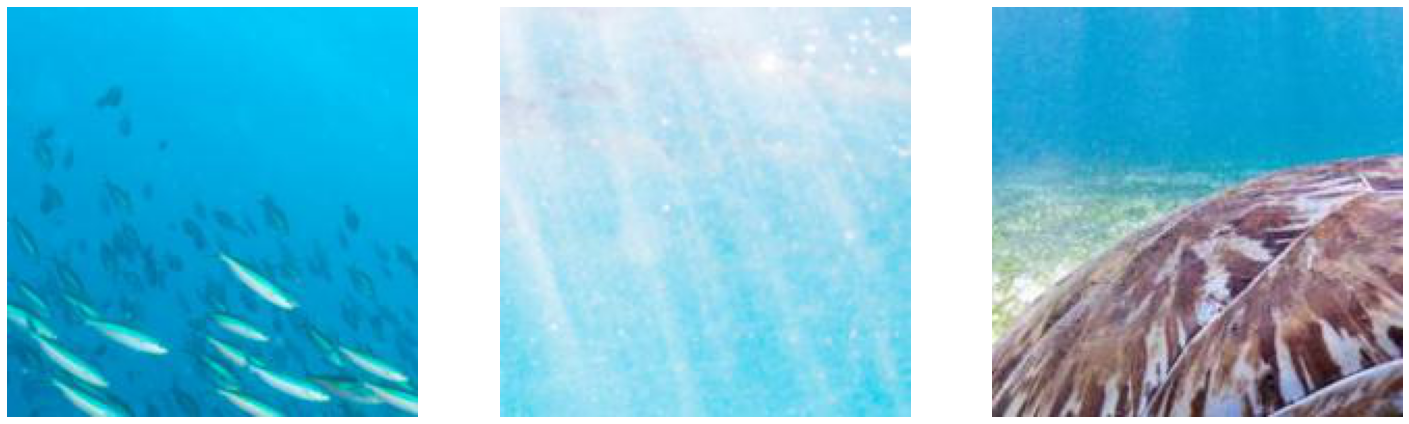

In [26]:
img1 = io.imread(Path(path_noface,'noface_10.jpg'))
img2 = io.imread(Path(path_noface,'noface_123.jpg'))
img3 = io.imread(Path(path_noface,'noface_45.jpg'))

figTf, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,25))
ax1.imshow(img1)
ax2.imshow(img2)
ax3.imshow(img3)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
a=1

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="cnn"></a>


# Section 3: Custom CNN Dask Distribution

This section showcases how a machine learning model can be distributed using standard dask methods. The face and noface images are loaded into dask arrays. These are rechunked so there is approximatly 333 images in a chunk. With 4000 images this creates roughly 12 majour chunks to be processed on 6 workers. These are persisted and passed into the custom cnn distribution.

### Algorithm Daskability 
An issue with distributed machine learning is that gradient descent cannot be co-ordinated seemlessly between the workers without a lot of slow interworker communication. This means the workers have to train on different data seperatly with the results being merged intermitantly. This implimentation splits the data evenly among the workers and combines the results after each worker has trained one "epoch" on the all data it has. When the workers have finished the weights are compared by the jupyter machine. The weights with the lowest loss are kept and the others are discarded. These weights are saved on each worker for another training.

### Memory Between Worker Tasks
The workers have 1/6 of the data saved on them but there are 12 chunks. The worker needs to have knowledge of the weights that were trained on the previous chunk. No solution was found to impliment this with python variables on dask. This was solved by saving the weights to a local pickle file. When a second chunk is loaded in the worker can read the old weights and carry on training from that point.

### Tensorflow Non Compatability
The CNN model variable could not be passed as a regular python variable to a function to be ran on a worker. This created an error. To solve this issue a g6.py file was created with the cnn variable pre built on it. This file is saved on each worker. Thus the cnn could be called in each worker with import g6, g6.cnn. Additional functions used by the worker are also placed on the g6 file. This reduces traffic on the cluster when running these functions on the workers.

### Unmanaged Memory
There were memory issues. The unmanged memory continuously increased at a high pace. Trimming with the malloc function only released a small proportion of the memory. The extensive use of the del function helped dramatically. An earlier version of the code used a dask data frame instead of dask arrays. This helped to keep the lables with the images. Althought the numpy array images only fitted into a 'cell' of the data frame if it was contained within list. This prevented dask from accuratly measuring the size of the data within the data frame. which contributed significantly to the unmanaged memory issue. This was resolved by switching to the dask array architecture.

### Dask Options
When it comes to distribution in dask there are many options. We implimented the code both in a dask dataframe and in dask arrays. We finally used the dask arrays. Although dask bags were going to be our next try if it were to fail. Dask also allows a very flexible framework with dask delayed. Many combinations of these options were thought of and a few were trialed to find the final working solution that performed adequatly. The images are loaded as dask arrays. The face images are stacked ontop of the noface images. Thus the lables are encoded in a dimension of the dask array. This is chunked and persisted across the workers. These chunks are 

In [73]:
#make the g6.py file to move some functions straight to the workers
#This reduces traffic when running these functions on the workers
# It was also the only way to get the cnn on the worker, as it couldn't be passed in a function.

#remove old g6.py file
try:
    os.system('rm g6.py')
    client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "g6.py")))
except: print("No g6.py file was on the workers or the current machine, adding it now")
#the code below is displayed as such for syntax highlighting. It is then made into a string and written to a file to be sent to the workers and used as a g6 package
from tensorflow.keras import models, layers
import tensorflow as tf
import pickle
def build_cnn():
    cnn = models.Sequential([
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #summary
    #print(cnn.summary())
    return cnn

cnn = build_cnn()

#extracting the weights from a cnn
def get_w(cnn):
    layer_w = [lay.get_weights() for lay in cnn.layers]
    return layer_w

#changing the weights of the cnn
def set_w(cnn,weights):
    for lay,w in zip(cnn.layers, weights):
        lay.set_weights(w)
    return cnn


#make a pickle file on the worker with the initial weights
def weights_init():
    weights = get_w(cnn)
    f_weights = open(Path(path_weights), 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    
# once the weights have been trained. This brings them from the workers to this machine for validation
def weights_get():
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    return weights
#weights = list(client.run(weights_get).values())

def loss_get():
    f_loss = open(path_loss,'rb')
    loss = pickle.load(f_loss)
    f_loss.close()
    return loss
#weights = list(client.run(weights_get).values())

def acc_get():
    f_acc = open(path_acc,'rb')
    acc = pickle.load(f_acc)
    f_acc.close()
    return acc
#weights = list(client.run(weights_get).values())



#now we have the best weights we need to write them to each worker so they can re-train from the best weights
def weights_set_best(weights_best):
    f_weights = open(path_weights,'wb')
    pickle.dump(weights_best,f_weights)
    f_weights.close()
    del f_weights, weights_best
    
contents = "\
from tensorflow.keras import models, layers\n\
import tensorflow as tf\n\
import pickle\n\
path_weights='"+str(path_weights)+"'\n\
def build_cnn():\n\
    cnn = models.Sequential([\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        #dense\n\
        layers.Flatten(),\n\
        layers.Dense(50, activation='relu'),\n\
        layers.Dense(2, activation='softmax')\n\
    ])\n\
    # compile\n\
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\
    #summary\n\
    #print(cnn.summary())\n\
    return cnn\n\
\n\
cnn = build_cnn()\n\
\n\
def get_w(cnn):\n\
    layer_w = [lay.get_weights() for lay in cnn.layers]\n\
    return layer_w\n\
#changing the weights of the cnn\n\
def set_w(cnn,weights):\n\
    for lay,w in zip(cnn.layers, weights):\n\
        lay.set_weights(w)\n\
    return cnn\n\
\n\
#make a pickle file on the worker with the initial weights\n\
def weights_init():\n\
    weights = get_w(cnn)\n\
    f_weights = open(path_weights, 'wb')\n\
    pickle.dump(weights, f_weights)\n\
    f_weights.close()\n\
    \n\
# once the weights have been trained. This brings them from the workers to this machine for validation\n\
def weights_get():\n\
    f_weights = open(path_weights,'rb')\n\
    weights = pickle.load(f_weights)\n\
    f_weights.close()\n\
    return weights\n\
#now we have the best weights we need to write them to each worker so they can re-train from the best weights\n\
def weights_set_best(weights_best):\n\
    f_weights = open(path_weights,'wb')\n\
    pickle.dump(weights_best,f_weights)\n\
    f_weights.close()\n\
    del f_weights, weights_best"

#write the file this this machine on the same dir as this notebook
f_py = open("g6.py",'w')
f_py.write(contents)
f_py.close()

#upload the file to the workers so it can be imported on the workers
client.upload_file('g6.py')

#use the following commmand to remove unwanted files that have been uploaded
#client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "file.py")))

{'tcp://10.67.22.108:36153': {'status': 'OK'},
 'tcp://10.67.22.110:35555': {'status': 'OK'},
 'tcp://10.67.22.138:41457': {'status': 'OK'},
 'tcp://10.67.22.203:39515': {'status': 'OK'},
 'tcp://10.67.22.67:38069': {'status': 'OK'},
 'tcp://10.67.22.75:35645': {'status': 'OK'}}

In [74]:
#You can checked it worked by initalising the weights
# import g6
# client.run(g6.weights_init)

In [9]:
#define the function that will train on each partition. It will load weights, train, then write the improved weights over the same file
@dask.delayed
def train(chunk):
    #convert the chunk to a form that will go into the cnn
    face = chunk[:,0,:,:,:]
    noface = chunk[:,1,:,:,:]
    labelsF = np.ones(len(face))
    labelsNF = np.zeros(len(noface))
    
    data = tf.convert_to_tensor(np.concatenate((face,noface), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del face, labelsF, noface, labelsNF
    #---------------------------------------------------
    #get init/best weights from pickle file 
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    del f_weights
    cnn = g6.set_w(g6.cnn, weights)
    fit = cnn.fit(data,labels, epochs = 1, shuffle=True)
    loss = fit.history['loss'][-1]
    acc = fit.history['accuracy'][-1]
    
    f_acc = open(path_acc, 'wb')
    pickle.dump(acc, f_acc)  
    f_acc.close()
    
    f_loss = open(path_loss, 'wb')
    pickle.dump(loss, f_loss)  
    f_loss.close()
    
    weights = g6.get_w(cnn)
    f_weights = open(path_weights, 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    del f_weights, weights, fit, data, labels, cnn

#because this function returnes nothing, delayed was more convenient than dask.array.map_blocks()

In [13]:
#once the weights have been trained, we need to evaluate the accuracy they provide
# The workers find the acc of different chunks in parralell. The mean acc of the chunks is the overall accuracy.
#The function loads the weights from the same place the trainer saved them.
@dask.delayed
def evaluate(chunk,weights):
    #convert the chunk to a form that will go into the cnn
    face = chunk[:,0,:,:,:]
    noface = chunk[:,1,:,:,:]
    labelsF = np.ones(len(face))
    labelsNF = np.zeros(len(noface))
    
    data = tf.convert_to_tensor(np.concatenate((face,noface), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del face, labelsF, noface, labelsNF
    
    cnn = g6.set_w(g6.cnn,weights)
    loss, acc = cnn.evaluate(data,labels)
    del cnn, loss
    return acc


In [2]:
from dask.array.image import imread
#this will load the saved images from file into a dask array
# it is stacked so the face images are on top of the noface images, this is the second axis
def getData(vis=False):    
    if vis:
        face = imread(str(path_face)+'/*').persist()
        noface = imread(str(path_noface)+'/*').persist()
        data = [face,noface]
        data = da.stack(data,axis=1)
        data.visualize()
        
    else:    
        face = imread(str(path_face)+'/*')
        noface = imread(str(path_noface)+'/*')
        data = [face,noface]
        data = da.stack(data,axis=1)
    #display(face)
    #display(noface)    
    #display(data)
    del face, noface
    return data

#data = getData(vis=True)

## Visualising Training 

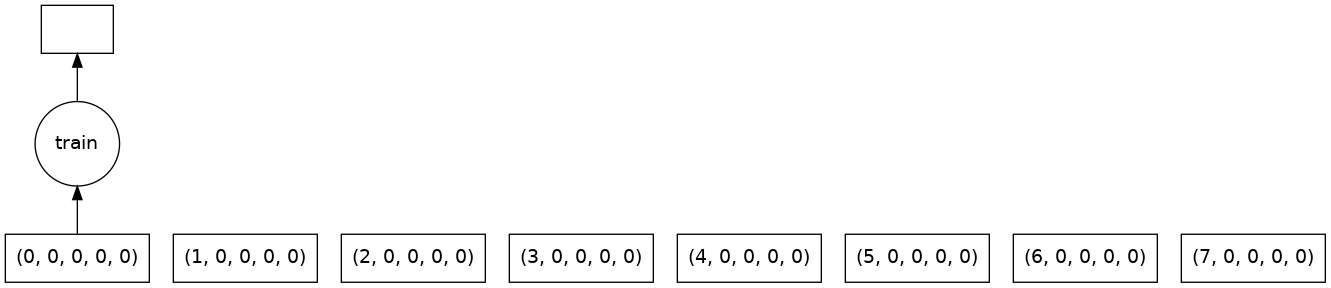

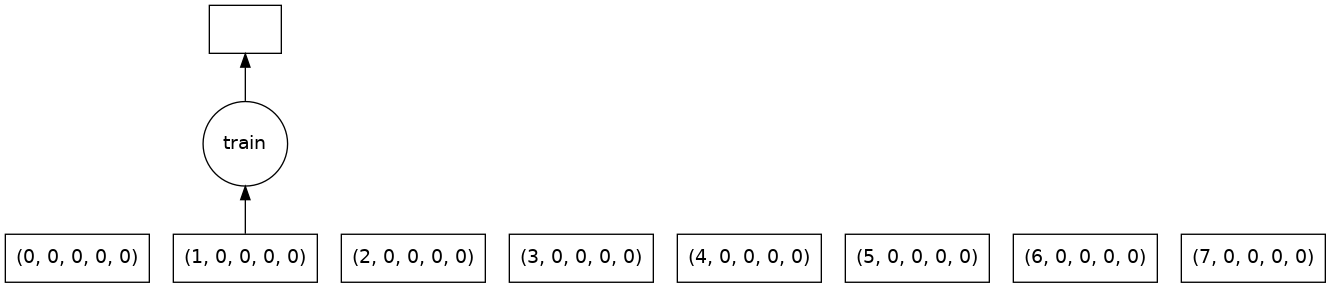

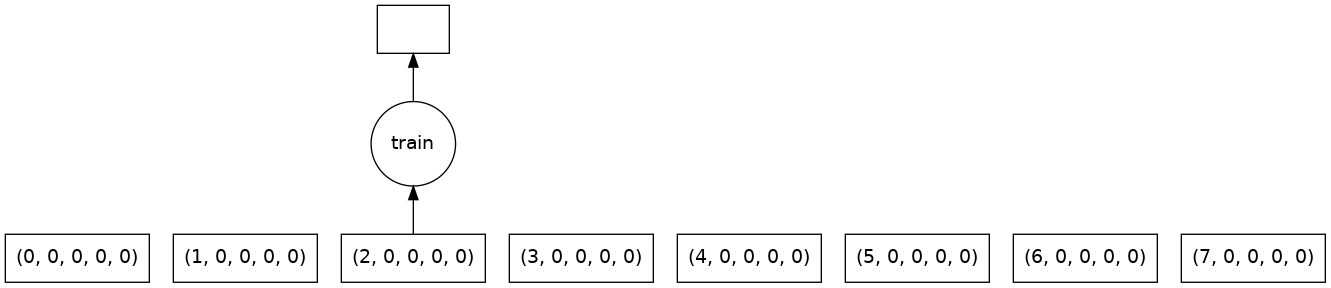

In [10]:
#Visualising the training of one chunk
data=getData()
data=data.rechunk(chunks=(int(500/2),2,198,198,3)).persist()
data= data.to_delayed().ravel()
delayed = [train(d) for d in data]
delayed[0].visualize()
display(delayed[0].visualize())
display(delayed[1].visualize())
display(delayed[2].visualize())

## Visualising Validation

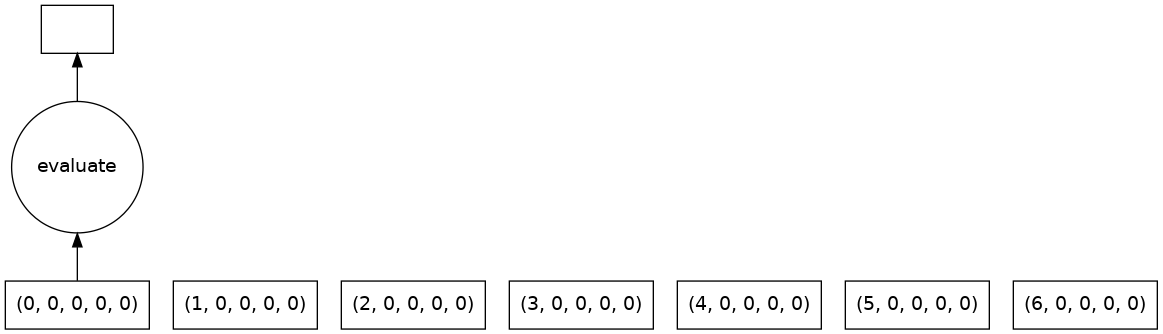

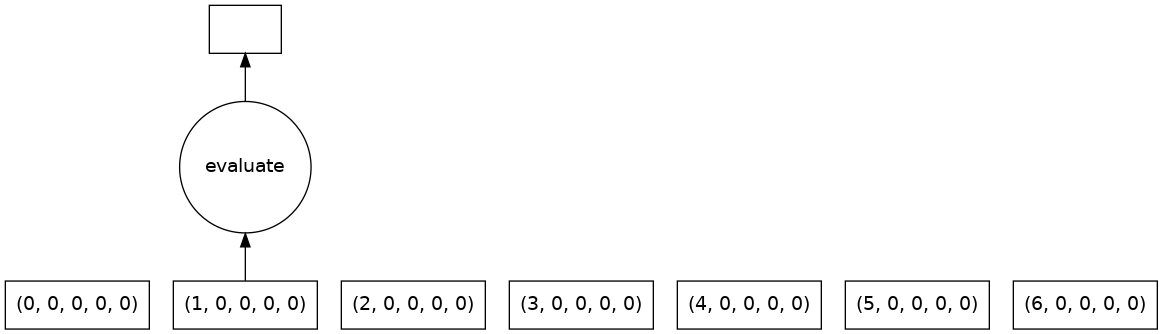

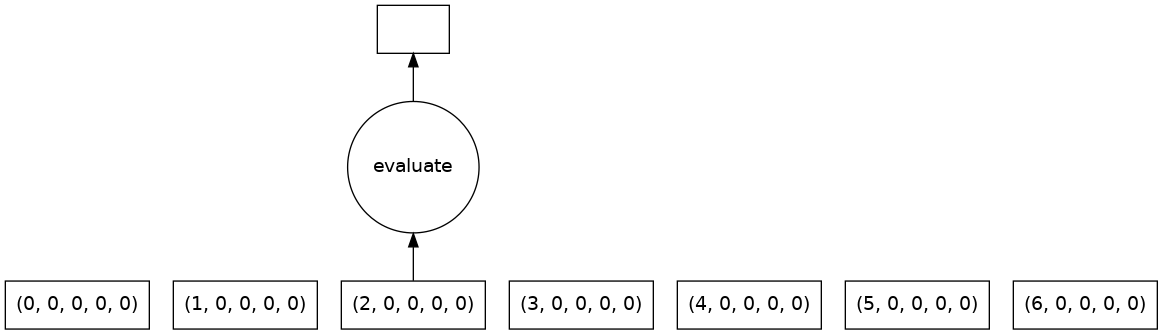

In [31]:
#Visualising the training of one chunk
data=getData()
data=data.rechunk(chunks=(int(500/2),2,198,198,3)).persist()
data=data.to_delayed().ravel()
delayed=[evaluate(d) for d in data]
display(delayed[0].visualize())
display(delayed[1].visualize())
display(delayed[2].visualize())

In [78]:
import g6 #our package we defined earlier, has weight file saving functions and the cnn variable

#The heart and soul
#This ties it all together to distribute the training of the cnn. On n workers we train data/n on each worker. data/n is split into chunks manageable on the ram. A worker loads in a chunk of its data/n and trains the cnn on it for 1 epochs. Then it saves the weights, training accuracy and loss to a file. When it gets the next chunk it loads the last weights and trains on top of them again. After it has repeated this for all of its chunks, we have a set of weights that has been trained on data/n. This happens for all n workers, then we have n sets of weights.

#These weights and their losses are loaded into the jupyter machine. The weights with the lowest loss is then saved into each worker for the next itteration of training.

#Then we do the distributed evaluation for the final best weights. Each worker has its data_eval/n saved locally in chunks. It loads one chunk at a time and evaluated the cnn accuracy with the weights being tested. Each worker returnes a collection of accuracies for each chunk evaluated. Finally all chunk accuracies are returned to this jupyter machine. Here we find the mean to know the true accuracy of the weights over all of the data. 

#images per chunk allows us to control how much the workers have to handle. I found chunking by bytes to be too inaccurate.
#frac_tr is the ratio of training to validation data. I suspect this should be kept low. Our goal is good performance analysis not a good cnn. With less training data it takes longer to train which amplifies performance gaps between systems. If both systems get 0.99 accuracy in 0.2 +- 0.02 seconds its difficult to say which is better. But if one is an inefficiant model it will show as each inefficiency adds up in a longer run. Also with a large validation set we get more accurate accuracy readings. This means our performance analysis for time to 0.95 accuracy is more reliable.    

#get and split the data
data = getData().persist()
frac_tr = 0.8

im_per_chunk=333

m_t = int(len(data)*frac_tr)
data_tr = data[:m_t].rechunk(chunks=(int(im_per_chunk/2),2,198,198,3)).persist()
data_val = data[m_t:].rechunk(chunks=(int(im_per_chunk/2),2,198,198,3)).persist()
wait(data_tr)

del data, frac_tr, m_t


def cnn_dist(data_tr, nitter=1, verbose=True):
    try: 
        del weights_best, loss_best, acc_best
    except: print('Another Run')
    
    data_tr = data_tr.to_delayed().ravel()
    #initialising the weights stored locally on the workers
    client.run(g6.weights_init)

    for i in range(nitter):
        if verbose: print('Training Itteration:',i)
        #train on the distributed training dataframe, loading and saving the weights from a file
        dd.compute(*[train(dtr) for dtr in data_tr])
        #del data_tr
        
        if verbose: print('getting trained weights:',i)
        #the weights have been trained. This brings them from the workers to this machine for validation
        weights = list(client.run(g6.weights_get).values())
        loss = list(client.run(loss_get).values())
        acc = list(client.run(acc_get).values())
        weights_best = weights[np.argmin(loss)]
        loss_best = np.min(loss)
        acc_best = np.max(acc)
        
        if verbose: print('The best training accuracy amongst the weights found is:',acc_best,'loss:',loss_best,'\n Setting the corresponding best weights for itteration:',i)
        client.run(g6.weights_set_best, weights_best)
        #The best weights found have been set, ready for the next training itteration
        
        del weights, loss, acc
    del data_tr
    return loss_best, acc_best, weights_best




In [79]:
from dask.distributed import performance_report
with performance_report(filename="cnn_dist_chunk333_itter5.html"):
    loss_best, acc_best, weights_best = cnn_dist(data_tr,nitter=5,verbose=True)

Another Run
Training Itteration: 0
getting trained weights: 0
The best training accuracy amongst the weights found is: 0.8042168617248535 loss: 0.7191608548164368 
 Setting the corresponding best weights for itteration: 0
Training Itteration: 1
getting trained weights: 1
The best training accuracy amongst the weights found is: 0.8614457845687866 loss: 0.6232593655586243 
 Setting the corresponding best weights for itteration: 1
Training Itteration: 2
getting trained weights: 2
The best training accuracy amongst the weights found is: 0.900602400302887 loss: 0.39477837085723877 
 Setting the corresponding best weights for itteration: 2
Training Itteration: 3
getting trained weights: 3
The best training accuracy amongst the weights found is: 0.9186747074127197 loss: 0.24249596893787384 
 Setting the corresponding best weights for itteration: 3
Training Itteration: 4
getting trained weights: 4
The best training accuracy amongst the weights found is: 0.9150943160057068 loss: 0.2502067685127

In [81]:
#Validation
data_val = data_val.to_delayed().ravel()
acc_val = np.mean(dd.compute(*[evaluate(dvl,weights_best) for dvl in data_val]))
print('The validation accuracy is:',acc_val)


The validation accuracy is: 0.8555988669395447


In [82]:
# run this cell to release the ram that the workers are hoarding. 
# only to be used for debugging memory leeks, there is a fancy way for automatic trimming
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://10.67.22.108:36153': 1,
 'tcp://10.67.22.110:35555': 1,
 'tcp://10.67.22.138:41457': 1,
 'tcp://10.67.22.203:39515': 1,
 'tcp://10.67.22.67:38069': 1,
 'tcp://10.67.22.75:35645': 1}

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="sklearn"></a> 
# Section 4: Dask Sklearn integration

<a id="data"></a> 
### Load all of the images into a single dask array 

In [2]:
import numpy as np
import dask_image
import dask.array as da
import dask.dataframe as dd
import dask.delayed
from dask.array.image import imread
import os


def load_turtles(path, kind='train'):
    f  = os.path.join(path, 'face/face*.jpg')
    nf = os.path.join(path, 'noface/noface*.jpg')
    
    #load all images
    images = da.concatenate([imread(f), imread(nf)])
    images=images.rechunk((40, 198,198, 3))   
    
    ##create numpy list of ,matching labels
    face_lb = np.ones(len(os.listdir(os.path.join(path, 'face')))) #fetch the 
    no_face_lb= np.negative(np.ones(len(os.listdir(os.path.join(path, 'noface')))))
    labels = np.append(face_lb, no_face_lb)
    labels= da.from_array(labels)

    return images, labels 

data_path = '/home/ubuntu/shared_local/'
X, y = load_turtles(data_path)

permutation = da.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

X.persist()
y.persist()

dask.array<slice_with_int_dask_array_aggregate, shape=(4000,), dtype=float64, chunksize=(4000,), chunktype=numpy.ndarray>

### What does the data look like?
Note this is better done before the data is distributed

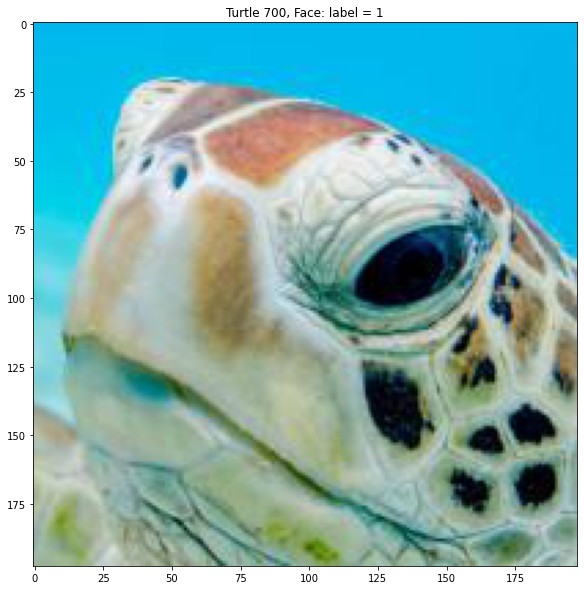

In [11]:
import matplotlib.pyplot as plt 

def plot_input(X_i, y, i):
    lb = ', No Face; label =-1'
    if y==1:
        lb=', Face: label = 1'
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.imshow(X_i)
    ax.set_title('Turtle '+ str(i)+lb)
    fig.show()


plot_input(X[700].compute(),y[700].compute(), 700)

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="futher_pre"></a> 
## Further Dask preprocessing
Sklearn will only allow the use of 2D arrays, therefore the turtle image data needs to be converted into a 2D array from the colour RGB array. To do this the image is converted to greyscale and the hog features are applied.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.feature import hog
import skimage

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:

            return np.array([local_hog(img) for img in X])

### Example

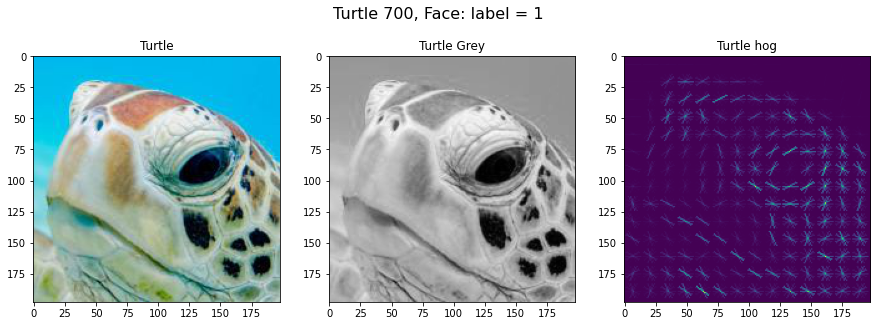

In [14]:
def plot_all_preprocessing(X_i, y_i, i): 
    #from skimage.feature import hog
    lb = ', No Face; label =-1'
    if y_i==1:
        lb=', Face: label = 1'
    turtle = X_i
    turtle_grey =  RGB2GrayTransformer().fit_transform(turtle)
    turtle_hog, turtle_hog_img = hog(
        turtle_grey, pixels_per_cell=(14,14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys')

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle('Turtle '+ str(i) +lb , fontsize=16)

    #[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]

    ax[0].imshow(turtle)
    ax[0].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle Grey')
    ax[2].imshow(turtle_hog_img)
    ax[2].set_title('Turtle hog')
    plt.show()

plot_all_preprocessing(X[700].compute(), y[700].compute(), 700)

### Bulk Preprocessing all images with Dask Delayed

In [4]:
@dask.delayed
def SGD_preprocessing_d(X):
    # create an instance of each transformer
    grayify = RGB2GrayTransformer()
    hogify = HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2,2), 
        orientations=9, 
        block_norm='L2-Hys'
    )
    scalify = StandardScaler()
    # call fit_transform on each transform converting X_train step by step
    X_gray = grayify.fit_transform(X)
    X_hog = hogify.fit_transform(X_gray)
    X_prepared = scalify.fit_transform(X_hog)
    #return np.shape(X_prepared)
    return X_prepared

chunk_size = 500
y= y.rechunk(chunks= (chunk_size))
X_prep = X.rechunk(chunks= (chunk_size, 198,198, 3)).to_delayed().ravel()
X_prep=da.concatenate([da.from_delayed(SGD_preprocessing_d(i), (chunk_size, 6084), dtype=np.float64) for i in X_prep])

### Split training and testing

In [5]:
from IPython.display import display

m_train = int(len(X_prep)*0.6) 
m_test = len(X_prep) - m_train

##only using for unprocessed turtle plot: wouldnt keep this for serious applications
X_train_raw, X_test_raw = X[:m_train], X[m_train:]

## Processed
X_train, X_test = X_prep[:m_train], X_prep[m_train:]
y_train, y_test = y[:m_train], y[m_train:]
print('m_training = ', m_train,'m_test =', m_test,'Total data =', m_train+m_test)

X_train = X_train.persist()
y_train = y_train.persist()
X_test = X_test.persist()
y_test = y_test.persist()

display(X_train, y_train)

m_training =  2400 m_test = 1600 Total data = 4000


dask.array<getitem, shape=(2400, 6084), dtype=float64, chunksize=(500, 6084), chunktype=numpy.ndarray>

dask.array<getitem, shape=(2400,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="mlp"></a> 
## Dask Wrappers: Multi-layer Perceptron classifier.
In the case in which the data cnnot fit on one machine the processing needs to be distributed.

In [11]:
from dask_ml.wrappers import Incremental
from sklearn.neural_network import MLPRegressor, MLPClassifier
from dask.distributed import performance_report

model = MLPClassifier(
    hidden_layer_sizes=(100,50),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=100,
    random_state=10,
    early_stopping=False,
    verbose=1,
    tol=0.001
)

model = Incremental(model, scoring="accuracy")

with performance_report(filename="Dask_sklearn_MLP_classifier_wrapper_fit.html"):
    model.fit(X_train, y_train, classes=[-1,1])

print('N iterations',  model.n_iter_)

N iterations 5


In [8]:
with performance_report(filename="Dask_sklearn_MLP_classifier_wrapper_predict_and_score.html"):
    print(model.score(X_test, y_test))

0.99375


<a href ="#contents">
<p style="text-align: right;">return to contents</p>
</a>  
<a id="grid"></a> 

## Sklearn Joblib with  dask: GridSearch
In the case where you are fortunate to be able to fit all of the data on a single machine the joblib the .compute function can be used. The .compute method takes a collection and returns a single future. In order to use the joblib dask add-in for sklearn we computed the data to recive numpy arrays. This only works on estimators where you can specify n_jobs. 

In [40]:
from dask_ml.datasets import make_classification
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDClassifier

X_train = X_train.rechunk(chunks= (400, 6084))
y_train = y_train.rechunk(chunks= (400))

##maybe rechunck the test
X_train = X_train.compute()
X_test_raw = X_test_raw.compute()
y_train = y_train.compute()
X_test = X_test.compute()
y_test = y_test.compute()

 ### Imports

In [41]:
import numpy as np
from dask.distributed import Client
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

### Run

In [22]:
param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

model = SVC(kernel='rbf')
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=10)

with joblib.parallel_backend('dask'):
    search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


### Results

In [23]:
search.best_score_

0.9966666666666667

In [24]:
search.best_params_

{'tol': 0.001, 'gamma': 0.0001, 'class_weight': 'balanced', 'C': 1000000.0}

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="forest"></a> 

## Sklearn Joblib with  dask: Random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0)

with joblib.parallel_backend('dask'):
    clf.fit(X_train, y_train)
    
clf.score(X_test, y_test)

0.98875

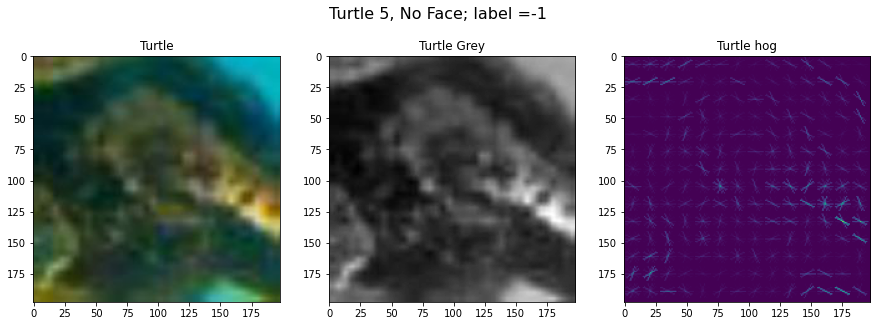

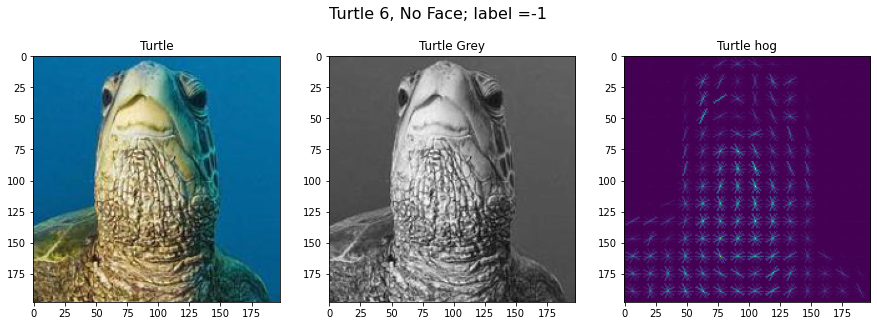

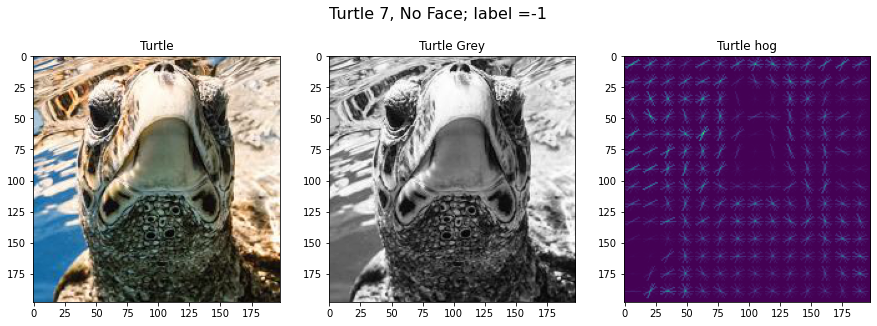

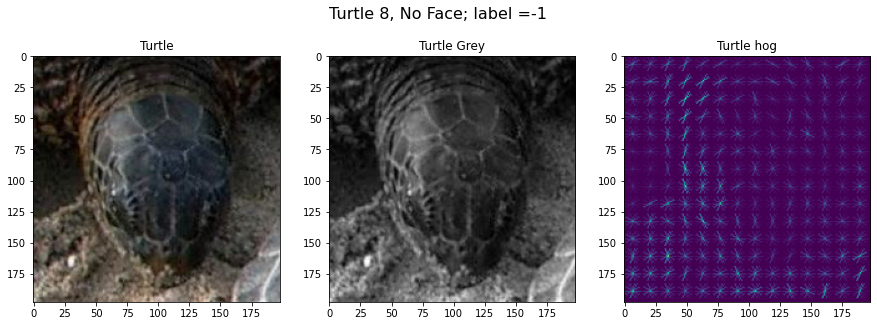

[None, None, None, None]

In [44]:
y_pred=clf.predict(X_test)
X_fails=X_test_raw[y_pred!=y_test]
y_fails=y_pred[y_pred!=y_test]
import matplotlib.pyplot as plt 
def plot_all_preprocessing(X_i, y_i, i): 
    #from skimage.feature import hog
    lb = ', No Face; label =-1'
    if y_i==1:
        lb=', Face: label = 1'
    turtle = X_i
    turtle_grey =  RGB2GrayTransformer().fit_transform(turtle)
    turtle_hog, turtle_hog_img = hog(
        turtle_grey, pixels_per_cell=(14,14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys')

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle('Turtle '+ str(i) +lb , fontsize=16)

    #[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]

    ax[0].imshow(turtle)
    ax[0].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle Grey')
    ax[2].imshow(turtle_hog_img)
    ax[2].set_title('Turtle hog')
    plt.show()

##plot 5 fails to illustrate 
[plot_all_preprocessing(X_fails[i], y_fails[i], i) for i in range(5, 9)] 

<a id="perf"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  

# Section 5: Performance testing

## Partition/Chunk Tests

The way in which the data is chunked is important for performance.

- Balanced Chunks: The number of chunks need to be distributed evenly among the workers. If there is an imbalance then at the end of every process the remainder need to be processed by one worker. This can significantly affect run times.

- Ram Limit: If the memory size of the chunks approaces the size of the workers ram this can significantly reduce the procesing time. 

The various functions we have outlined will be tested for the ideal chunk size. To do this the data will be rechunked, persisted and then placed into the function. The run times will be measured for the various chunk sizes.

In [ ]:
else: path_img = Path('/opt','workspace','data','images')

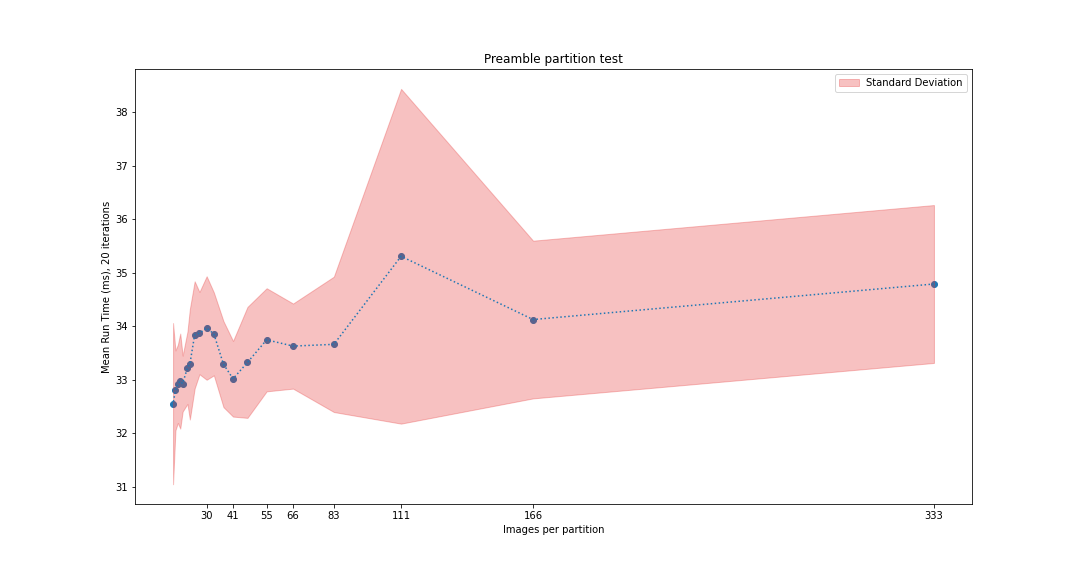

In [14]:
from IPython.display import Image
Image("/opt/workspace/notebooks/preamble.png")

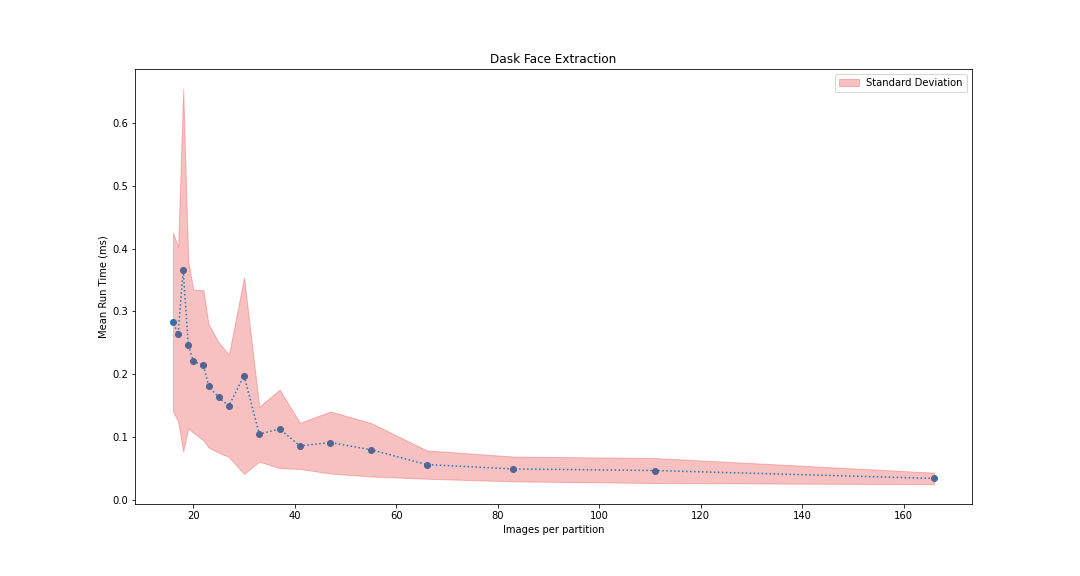

In [15]:
Image("/opt/workspace/notebooks/faceext.png")

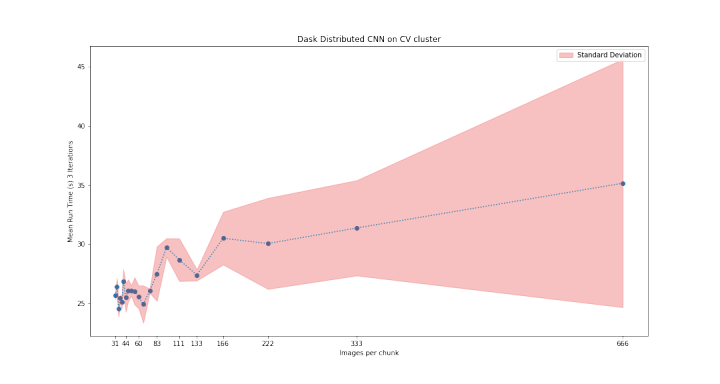

In [1]:
# import image module
Image("/home/ubuntu/daskdistributedCNN.png")

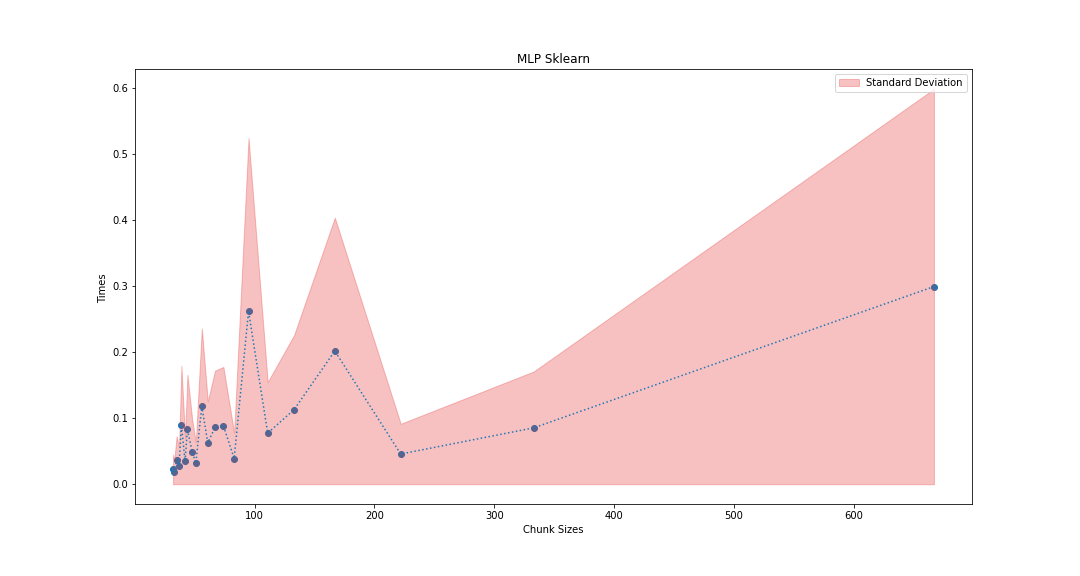

In [17]:
Image("/opt/workspace/notebooks/Mpltimes.png")

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="pre_perf"></a> 
## Futher Preprocessing Performance with Chunksize Test

In [18]:
client.restart()
X, y = load_turtles(data_path)

permutation = da.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

X.persist()
y.persist()

dask.array<slice_with_int_dask_array_aggregate, shape=(4000,), dtype=float64, chunksize=(4000,), chunktype=numpy.ndarray>

## With rechuncking

In [45]:
def chunk_test(funct, d_arr, chunk_sizes= [400,1000], n_iter=3, output_size = True, dtype=np.float64):
    if output_size: ##default output and input the same
        output_size=da.shape(d_arr)
    
    from dask.distributed import wait
    import time
    chunk = da.shape(d_arr)
    means=np.zeros(len(chunk_sizes)); stds =means #just initalises same

    def run_n_time(funct, d_arr, chunk, output):
        d_arr = d_arr.rechunk(chunks= chunk).to_delayed().ravel()
        d_arr = da.concatenate([da.from_delayed(funct(i), output_size, dtype=dtype) for i in d_arr])
        t1 = time.perf_counter()
        wait(d_arr.persist())
        t2 = time.perf_counter()
        return t2-t1 
    i=0
    for size in chunk_sizes:
        output =(size, *output_size)
        chunk = (size, *chunk[1:])  
        times = np.array([run_n_time(funct, d_arr, chunk, output)  for n in range(0,n_iter)])
        means[i]  = np.mean(times)
        stds[i]   = np.std(times)
        i+=1
        print('Chunk = ', i)
        
    means = means*1000
    stds = stds*1000
    return means, stds

n_workers = len(client.scheduler_info()['workers'].keys())
print("N workers = ", n_workers)
n_im = 4000
tasks=np.arange(1,22)*n_workers
chunk_size= n_im/tasks
chunk_sizes=np.sort(np.round(chunk_size))

n_iter=3
times, std = chunk_test(SGD_preprocessing_d, X, chunk_sizes=chunk_sizes, n_iter=n_iter, output_size=[6084])

Chunk =  1
Chunk =  2
Chunk =  3
Chunk =  4
Chunk =  5
Chunk =  6
Chunk =  7
Chunk =  8
Chunk =  9
Chunk =  10
Chunk =  11
Chunk =  12
Chunk =  13
Chunk =  14
Chunk =  15
Chunk =  16
Chunk =  17
Chunk =  18
Chunk =  19
Chunk =  20
Chunk =  21


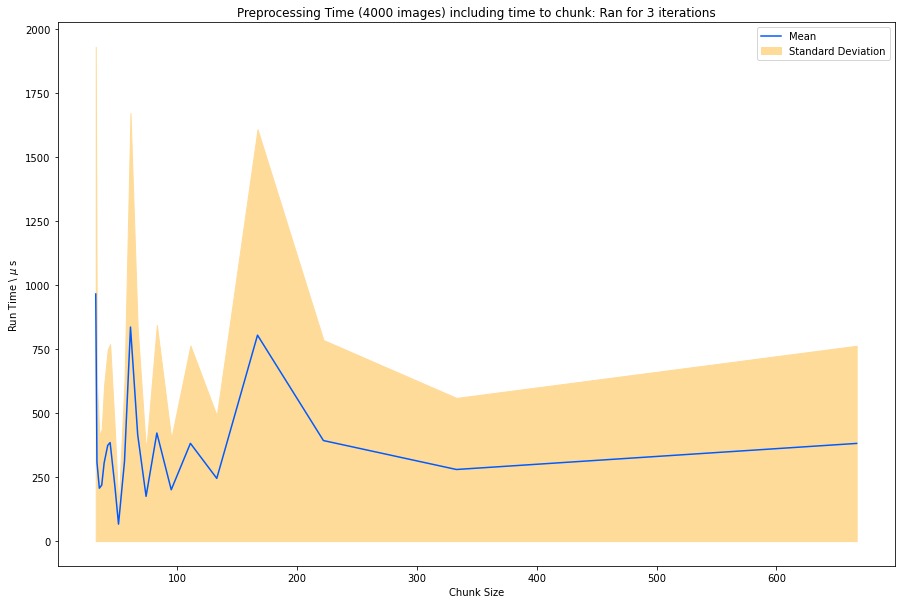

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(chunk_sizes, times, label = "Mean", color='#005AFF')
plt.fill_between(chunk_sizes,times+std,times-std, label='Standard Deviation', color='#ffdb99')
plt.xlabel('Chunk Size')
plt.ylabel('Run Time \ $\mu$ s')
plt.title('Preprocessing Time (4000 images) including time to chunk: Ran for ' + str(n)+' iterations' )
plt.legend()

## Without timing rechunking

In [39]:
def chunk_test(funct, d_arr, chunk_sizes= [400,1000], n_iter=3, output_size = True, dtype=np.float64):
    if output_size: ##defult output and input the same
        output_size=da.shape(d_arr)
    
    from dask.distributed import wait
    import time
    chunk = da.shape(d_arr)
    means=np.zeros(len(chunk_sizes)); stds =means #just initalises same

    def run_n_time(funct, d_arr, chunk, output):
        d_arr = d_arr.rechunk(chunks= chunk)
        wait(d_arr.persist())
        
        d_arr = d_arr.to_delayed().ravel()
        d_arr = da.concatenate([da.from_delayed(funct(i), output_size, dtype=dtype) for i in d_arr])
        t1 = time.perf_counter()
        wait(d_arr.persist())
        t2 = time.perf_counter()
        return t2-t1 
    i=0
    for size in chunk_sizes:
        output =(size, *output_size)
        chunk = (size, *chunk[1:])  
        times = np.array([run_n_time(funct, d_arr, chunk, output)  for n in range(0,n_iter)])
        means[i]  = np.mean(times) # np will convert
        stds[i]   = np.std(times)
        i+=1
        print('Chunk = ', i)
        
    means = means*1000
    stds = stds*1000
    return means, stds

n_workers = len(client.scheduler_info()['workers'].keys())
print("N workers = ", n_workers)
n_im = 4000
tasks=np.arange(1,22)*n_workers
chunk_size= n_im/tasks
chunk_sizes=np.sort(np.round(chunk_size))
n_iter=3
times2, std2 = chunk_test(SGD_preprocessing_d, X, chunk_sizes=chunk_sizes, n_iter=n_iter, output_size=[6084])

N workers =  6
Chunk =  1
Chunk =  2
Chunk =  3
Chunk =  4
Chunk =  5
Chunk =  6
Chunk =  7
Chunk =  8
Chunk =  9
Chunk =  10
Chunk =  11
Chunk =  12
Chunk =  13
Chunk =  14
Chunk =  15
Chunk =  16
Chunk =  17
Chunk =  18
Chunk =  19
Chunk =  20
Chunk =  21


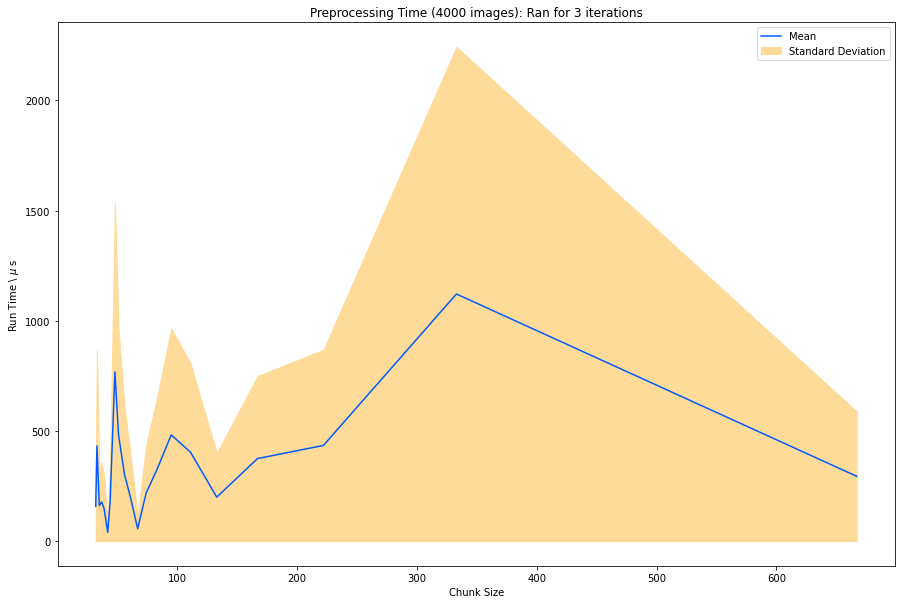

In [55]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(chunk_sizes, times2, label = "Mean", color='#005AFF')
plt.fill_between(chunk_sizes,times2+std2,times2-std2, label='Standard Deviation', color='#ffdb99')
plt.xlabel('Chunk Size')
plt.ylabel('Run Time \ $\mu$ s')
plt.title('Preprocessing Time (4000 images): Ran for ' + str(n)+' iterations' )
plt.legend()

<a id="mlp_perf"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
## MLP Wrapper Performance with Rechunking

In [25]:
def mlp_performance(X_arr, y_arr, chunk_sizes= [400,1000], n_iter=3):
    from dask.distributed import wait
    import time
    
    chunk_X = da.shape(X_arr)
    chunk_y = da.shape(y_arr)
    means=np.zeros(len(chunk_sizes)); stds =means #just initalises same

    model = MLPClassifier(
        hidden_layer_sizes=(100,50),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        max_iter=100,
        random_state=10,
        early_stopping=False,
        verbose=1,
        tol=0.001
    )

    model = Incremental(model, scoring="accuracy")

    def run_n_time(X_arr, y_arr, chunk_X, chunk_y):        
        X_arr = X_arr.rechunk(chunks= chunk_X)
        y_arr = y_arr.rechunk(chunks= chunk_y)
        wait(X_arr.persist())
        wait(y_arr.persist())

        t1 = time.perf_counter()
        model.fit(X_arr, y_arr, classes=[-1,1])
        t2 = time.perf_counter()
        return t2-t1 
    i=0
    for size in chunk_sizes:
        chunk_X = (size, *chunk_X[1:])
        chunk_y = (size, *chunk_y[1:])
        times = np.array([run_n_time(X_arr, y_arr, chunk_X, chunk_y)  for n in range(0,n_iter)])
        means[i]  = np.mean(times)
        stds[i]   = np.std(times)
        i+=1
        print('Chunk = ', i)
    return means, stds

n_workers = len(client.scheduler_info()['workers'].keys())
n_im = 4000
tasks=np.arange(1,22)*n_workers
chunk_size= n_im/tasks
chunk_size=np.sort(np.round(chunk_size))
n_iter = 3

mlp_times, mlp_stds= mlp_performance(X_train, y_train, chunk_sizes= chunk_size, n_iter=n_iter)

Chunk =  1
Chunk =  2
Chunk =  3
Chunk =  4
Chunk =  5
Chunk =  6
Chunk =  7
Chunk =  8
Chunk =  9
Chunk =  10
Chunk =  11
Chunk =  12
Chunk =  13
Chunk =  14
Chunk =  15
Chunk =  16
Chunk =  17
Chunk =  18
Chunk =  19
Chunk =  20
Chunk =  21


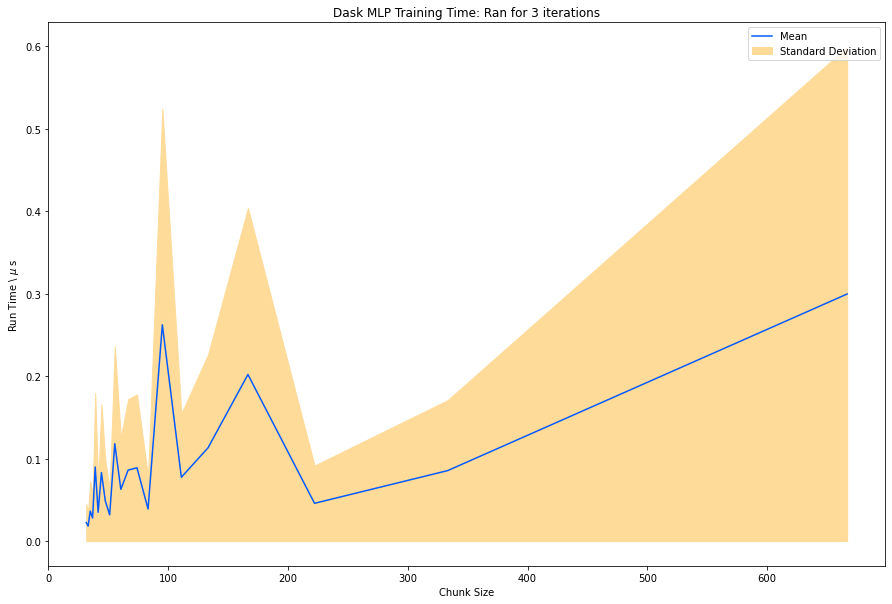

In [35]:
import matplotlib.pyplot as plt
n_iter=3
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(chunk_size, mlp_times, label = "Mean", color='#005AFF')
plt.fill_between(chunk_size, mlp_times+mlp_stds, mlp_times-mlp_stds, label='Standard Deviation', color='#ffdb99')
plt.xlabel('Chunk Size')
plt.ylabel('Run Time \ $\mu$ s')
plt.title('Dask MLP Training Time: Ran for ' + str(n_iter)+' iterations' )
plt.legend()

<a id="dash"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  

## Section 6: Dask dashboard our distributed CNN vs Sklearn implemented algorithm

In [2]:
# import image module
from IPython.display import Image

### Task Stream

Distributed CNN

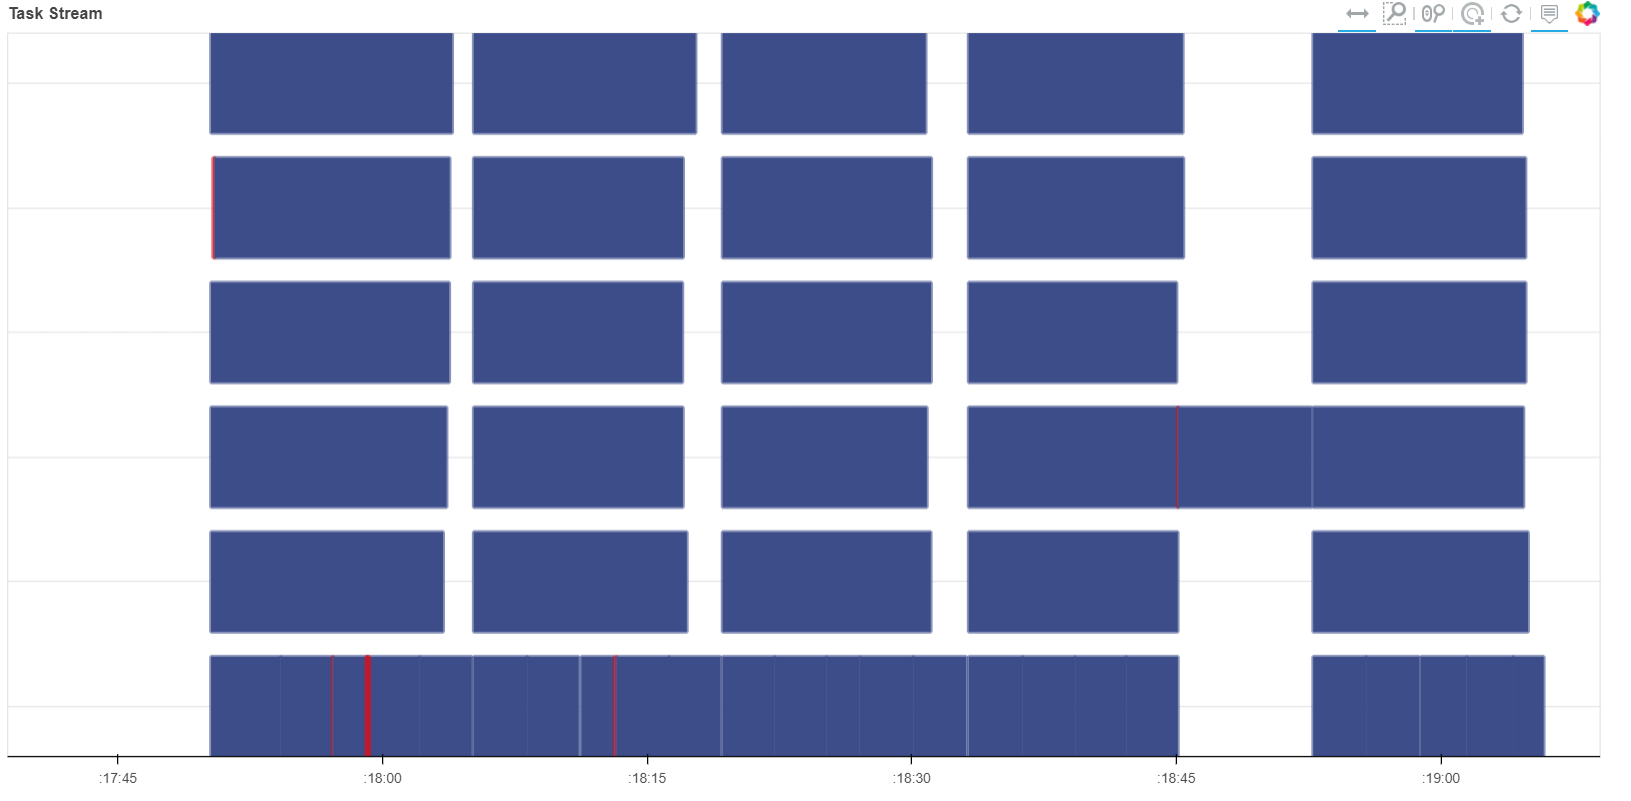

In [11]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\taskCNN.png")

SKLearn

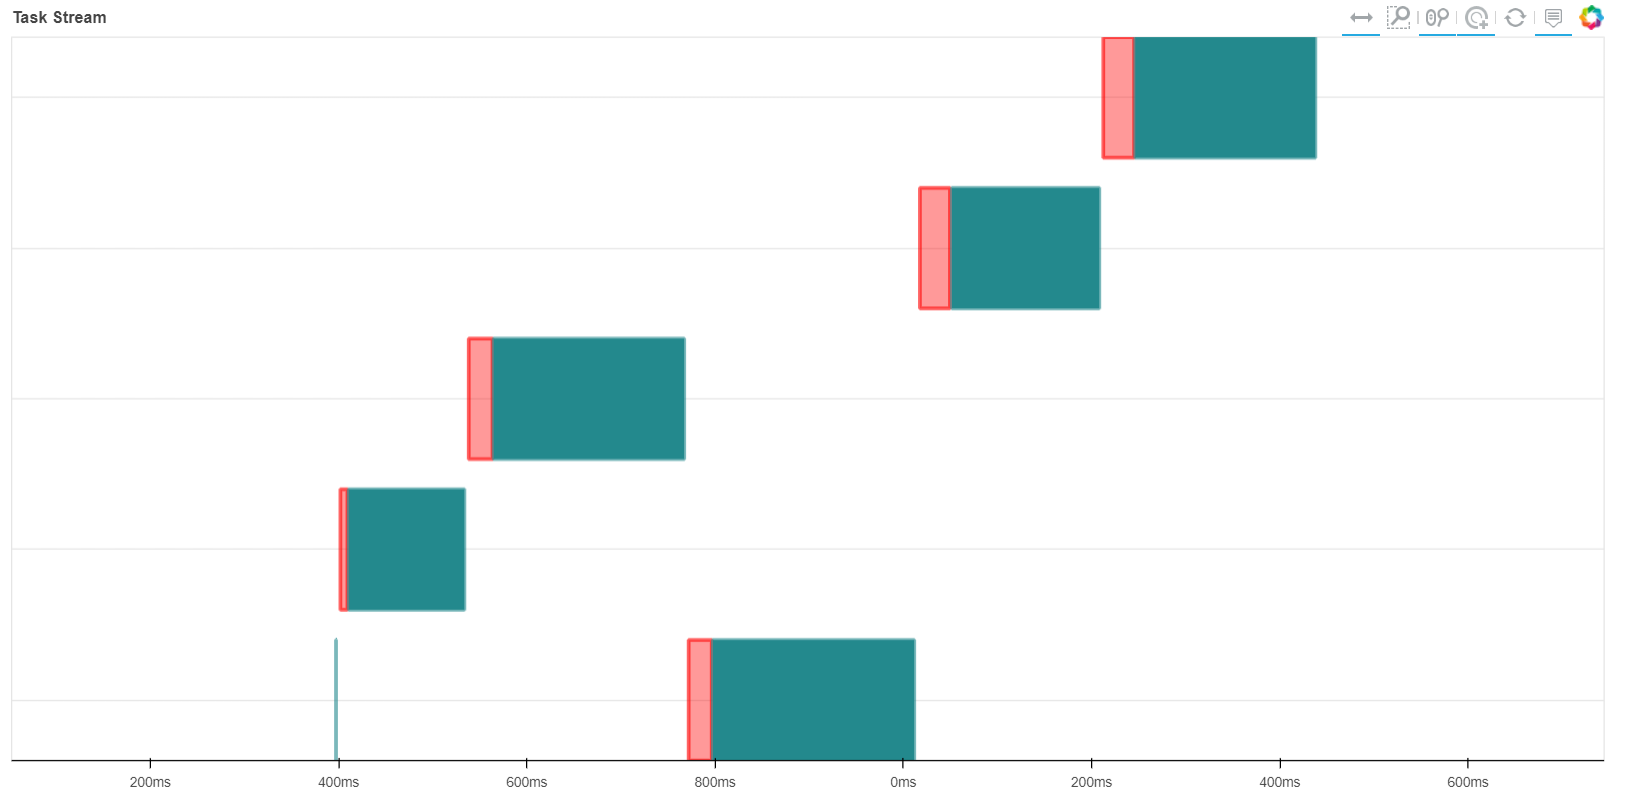

In [12]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\taskSK.png")

### Memory and CPU Usage

Distributed CNN

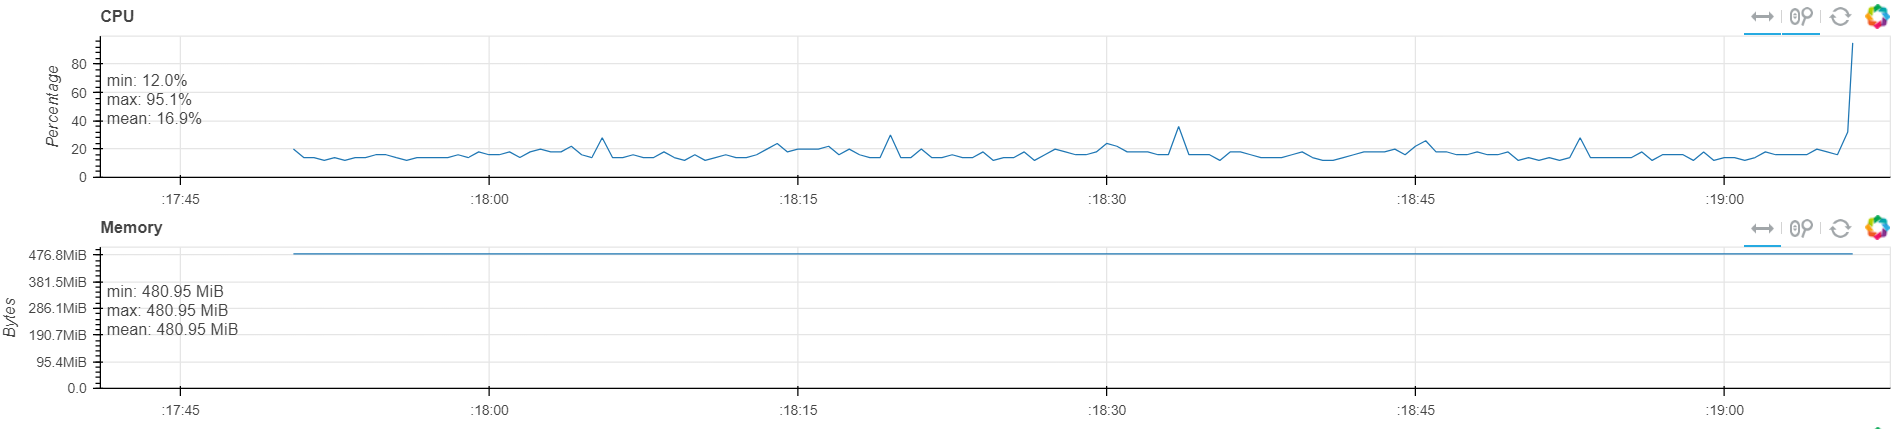

In [15]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\UsageCNN.png")

SKLearn

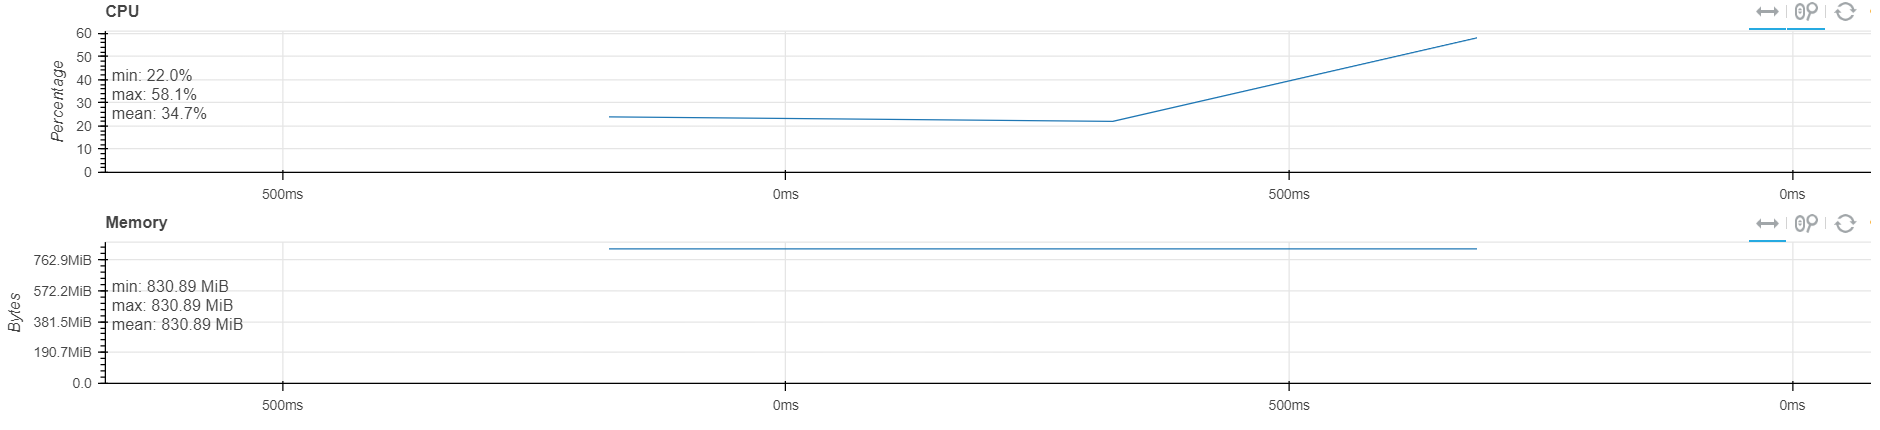

In [13]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\UsageCSK.png")

### Worker Profile

CNN

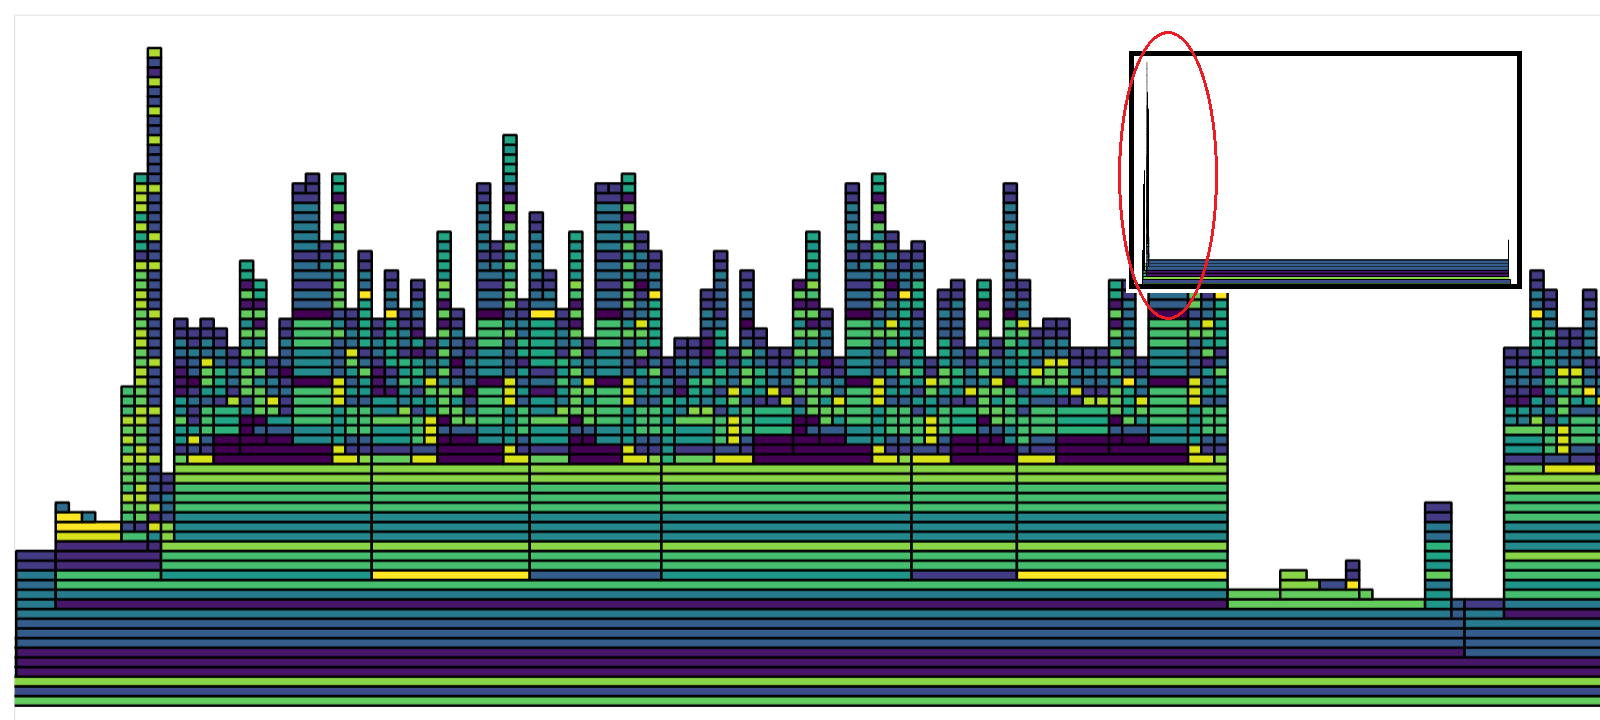

In [3]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\zoomCNN_W.png")

SKLearn

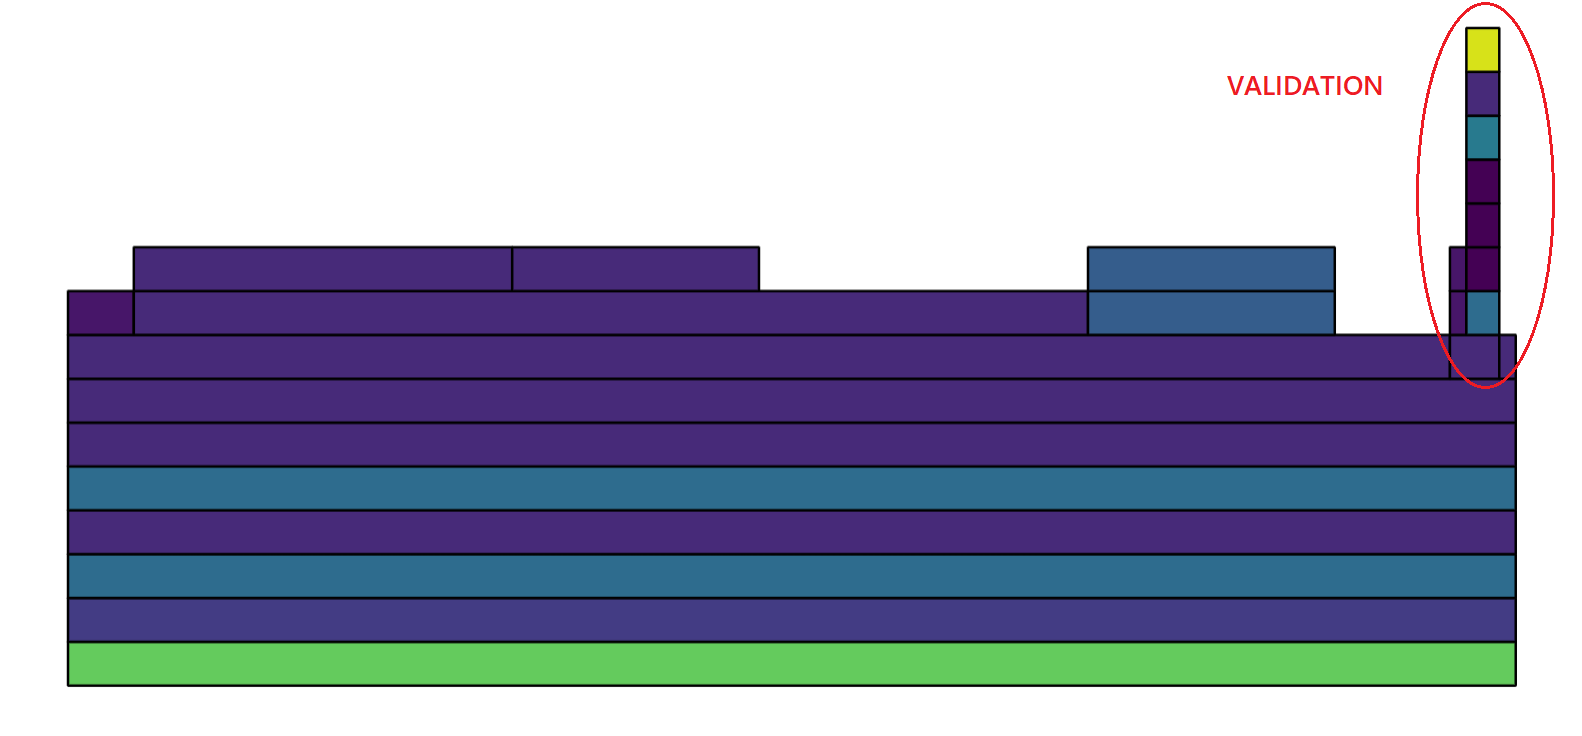

In [4]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\SK_W.png")

### Bandwidth

Distributed CNN

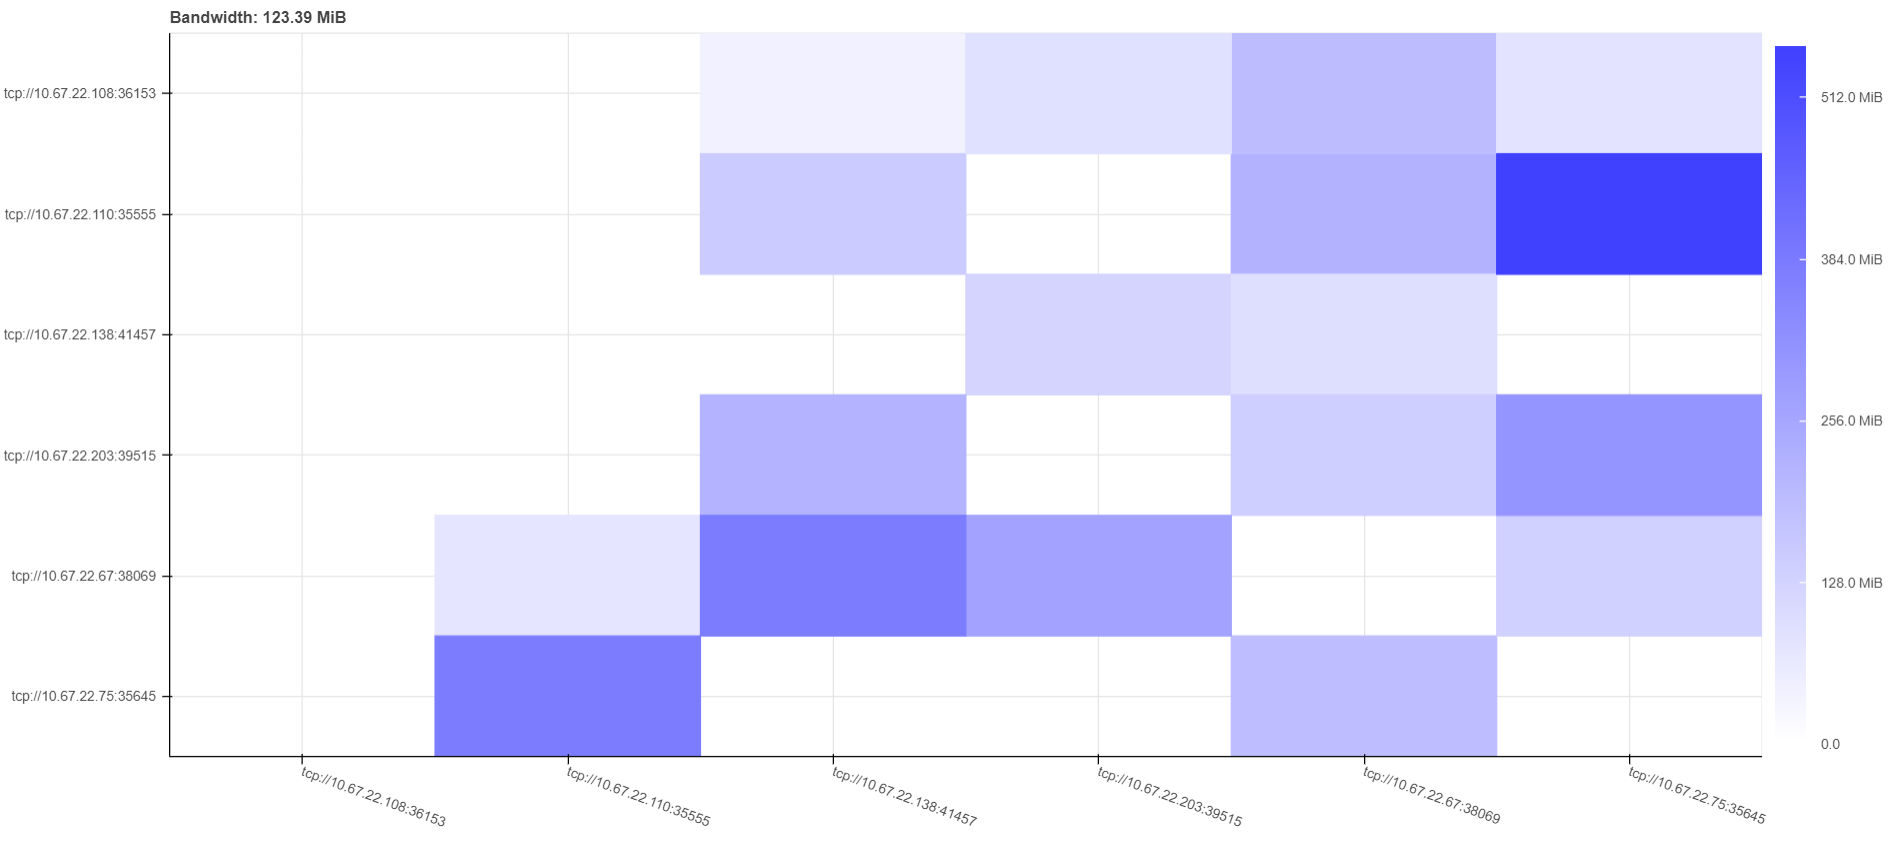

In [16]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\BandwidthCNN.png")

SKLearn

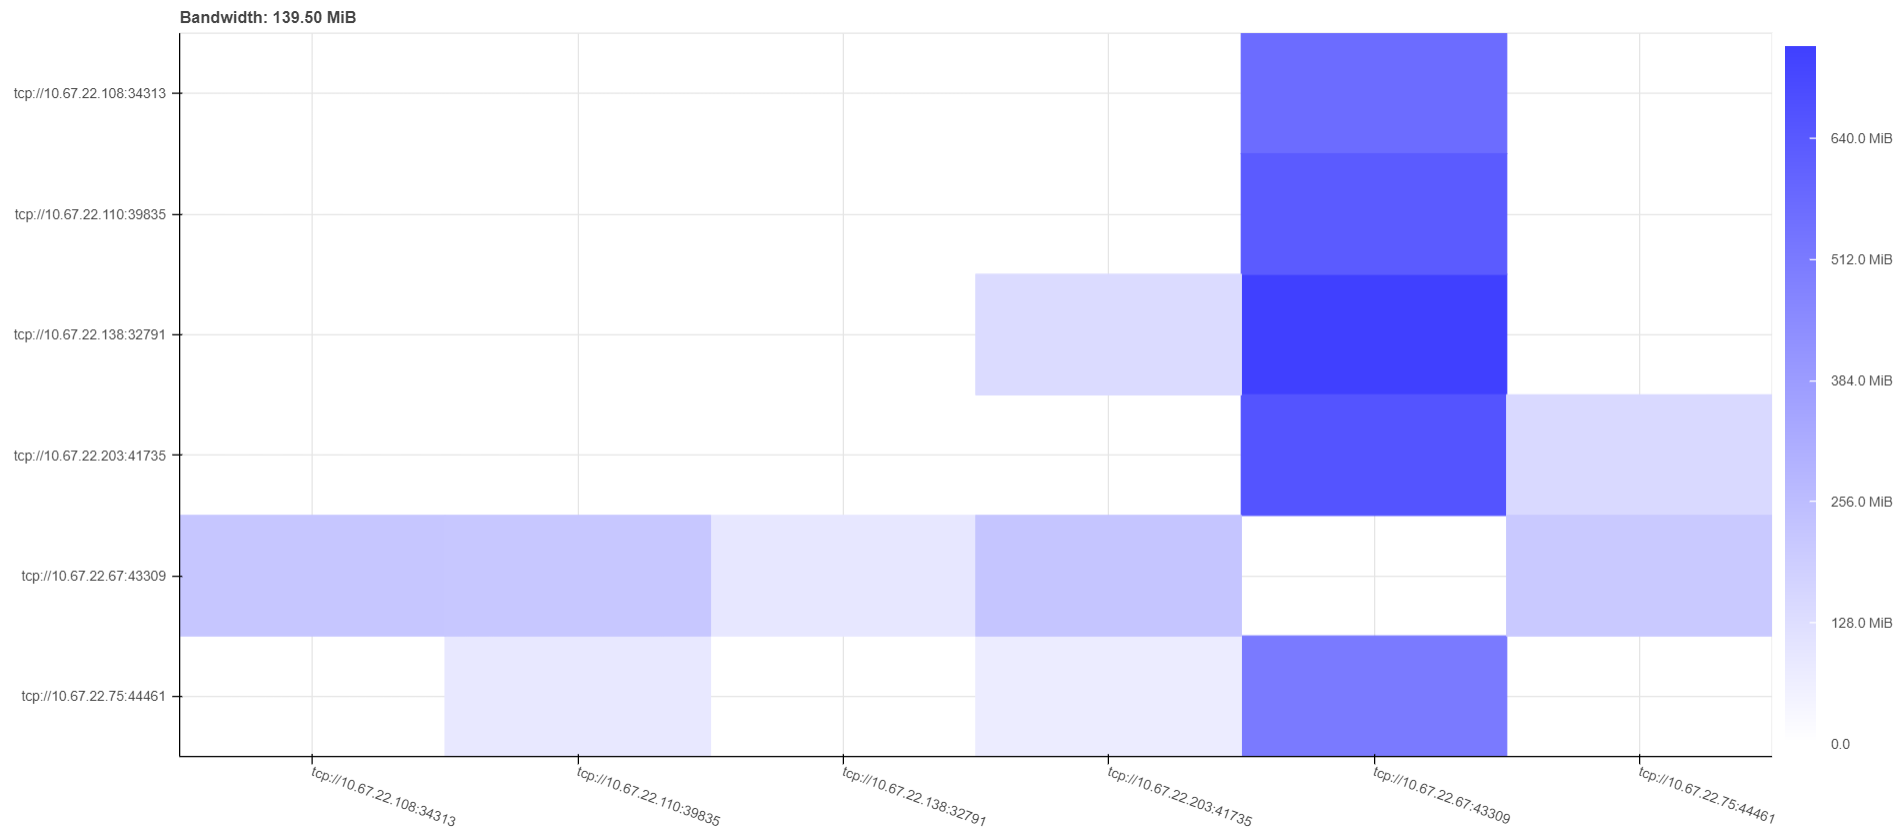

In [17]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\BandwidthSK.png")


## Dashboard  Videos

The memory use was not recorded in the dashboard html file. Therfore in each of the machine learning model was ran and screen captured, after 5 seconds after completion the unmanged memory was trimmed. 

### MLP Wrapper Test

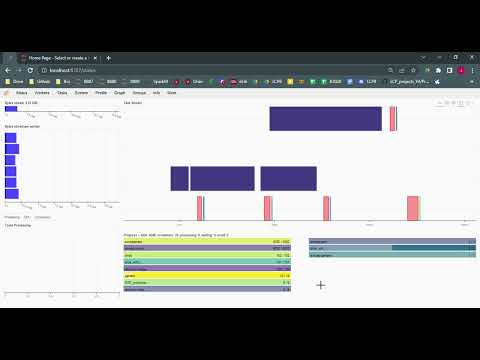

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('T_5azs2XD04', width=1000, height=500)

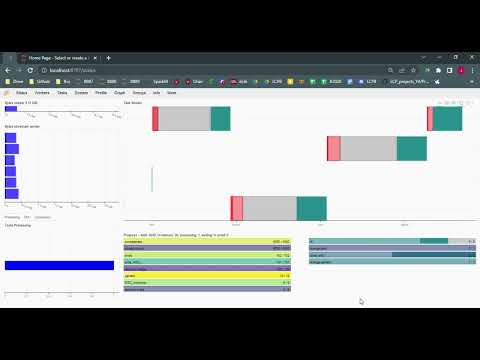

In [2]:
YouTubeVideo('CFUaPw8fUPw', width=1000, height=500)

### Custom Dask Tensorflow CNN

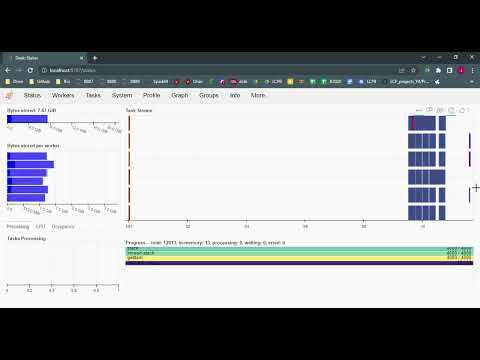

In [3]:
YouTubeVideo('zVw-95Xnj7g', width=1000, height=500)

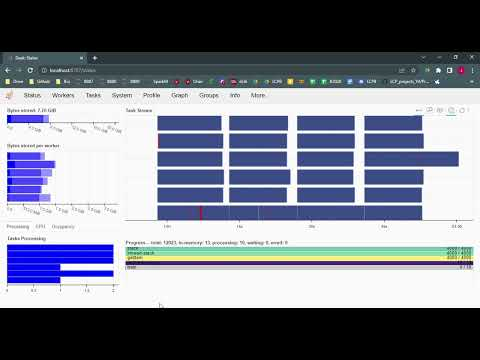

In [4]:
YouTubeVideo('t6cprUu1olM', width=1000, height=500)